In [1]:
# --- 1. 安装依赖 ---
!pip install xarray netCDF4 matplotlib geopandas rasterio rioxarray --quiet

# --- 2. 挂载Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- 3. 导入库 ---
import os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 补充必要的库
import glob
import json
from datetime import datetime, timedelta
import calendar
from pathlib import Path
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm
import gc


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 135.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 79.0 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# 检查路径和文件
import os

BASE_PATH = "/content/drive/MyDrive/3DCNN_Pipeline"
FEATURE_BASE = "/content/drive/MyDrive/Feature_Stacks"

print("检查路径...")
print(f"BASE_PATH存在: {os.path.exists(BASE_PATH)}")
print(f"FEATURE_BASE存在: {os.path.exists(FEATURE_BASE)}")

# 检查SO2数据目录
so2_dirs = ["SO2_2019", "SO2_2020", "SO2_2021", "SO2_2022", "SO2_2023"]
for dir_name in so2_dirs:
    dir_path = os.path.join(FEATURE_BASE, dir_name)
    exists = os.path.exists(dir_path)
    file_count = len([f for f in os.listdir(dir_path) if f.endswith('.npz')]) if exists else 0
    print(f"{dir_name}: 存在={exists}, 文件数={file_count}")

# 检查scaler文件
scaler_path = os.path.join(BASE_PATH, "artifacts", "scalers", "SO2", "meanstd_global_2019_2021.npz")
print(f"SO2 scaler文件存在: {os.path.exists(scaler_path)}")

检查路径...
BASE_PATH存在: True
FEATURE_BASE存在: True
SO2_2019: 存在=True, 文件数=365
SO2_2020: 存在=True, 文件数=366
SO2_2021: 存在=True, 文件数=365
SO2_2022: 存在=True, 文件数=365
SO2_2023: 存在=True, 文件数=365
SO2 scaler文件存在: True


In [ ]:
# ========= 修复后的SO2专用DataLoaderFactory =========
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Dict, List, Tuple, Optional
import random
from pathlib import Path
import logging

# 设置日志
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class SO2RandomGapMasker:
    """SO2专用缺口生成器 - 支持块级+像素级缺口组合"""

    def __init__(self,
                 pixel_gap_prob: float = 0.1,
                 patch_gap_prob: float = 0.15,
                 patch_size: int = 16,
                 climate_prior_weight: float = 0.8,
                 random_seed: int = 42):
        self.pixel_gap_prob = pixel_gap_prob
        self.patch_gap_prob = patch_gap_prob
        self.patch_size = patch_size
        self.climate_prior_weight = climate_prior_weight
        self.random_seed = random_seed

    def generate_gaps_with_climate_prior(self,
                                      X: torch.Tensor,
                                      y: torch.Tensor,
                                      climate_prior: torch.Tensor,
                                      seed: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """生成缺口并利用气候先验"""
        # 使用局部随机生成器
        g = torch.Generator(device=X.device if X.is_cuda else 'cpu').manual_seed(int(seed))

        # 确保输入是3D
        if X.ndim == 4:
            X = X.squeeze(0)  # (C, H, W)
        if y.ndim == 3:
            y = y.squeeze(0)  # (H, W)
        if climate_prior.ndim == 3:
            climate_prior = climate_prior.squeeze(0)  # (H, W)

        C, H, W = X.shape
        mask = torch.ones_like(y, dtype=torch.bool)

        # 1. 块级缺口 (模拟云层遮挡)
        if self.patch_gap_prob > 0:
            num_patches_h = H // self.patch_size
            num_patches_w = W // self.patch_size

            for ph in range(num_patches_h):
                for pw in range(num_patches_w):
                    if torch.rand((1,), generator=g, device=X.device) < self.patch_gap_prob:
                        start_h = ph * self.patch_size
                        end_h = min(start_h + self.patch_size, H)
                        start_w = pw * self.patch_size
                        end_w = min(start_w + self.patch_size, W)
                        mask[start_h:end_h, start_w:end_w] = False

        # 2. 像素级缺口 (增加随机性)
        if self.pixel_gap_prob > 0:
            pixel_mask = torch.rand((H, W), generator=g, device=X.device) > self.pixel_gap_prob
            mask &= pixel_mask

        # 3. 利用气候先验填充目标
        y_filled = y.clone()
        missing_pixels = ~mask
        if missing_pixels.any():
            # 用气候先验填充被遮挡的像素
            y_filled[missing_pixels] = climate_prior[missing_pixels]

        # 4. 应用缺口到输入数据
        mask_3d = mask.unsqueeze(0).expand(C, -1, -1)  # (C, H, W)
        X_masked = X.clone()
        X_masked *= mask_3d.float()

        return X_masked, mask.float(), y_filled

class SO2Dataset(Dataset):
    """SO2专用数据集"""

    def __init__(self,
                 split: str,
                 base_path: str,
                 feature_stacks_path: str,
                 scaler_dir: str,
                 gap_probability: float = 0.2,
                 random_seed: int = 42):
        """SO2专用数据集初始化"""
        self.split = split
        self.base_path = base_path
        self.feature_stacks_path = feature_stacks_path
        self.scaler_dir = scaler_dir
        self.gap_probability = gap_probability
        self.random_seed = random_seed

        # 加载SO2专用scaler参数
        self.scaler_params = self._load_so2_scaler()
        self.mv: torch.Tensor = self.scaler_params["mean_vec"]
        self.sv: torch.Tensor = self.scaler_params["std_vec"]

        # 缓存文件列表
        self.file_list = self._cache_so2_file_list()

        # 训练时的epoch
        self.epoch: int = 0

        # 初始化SO2专用缺口生成器
        self.gap_masker = SO2RandomGapMasker(
            pixel_gap_prob=gap_probability * 0.4,  # 40%用于像素级
            patch_gap_prob=gap_probability * 0.6,  # 60%用于块级
            patch_size=16,
            climate_prior_weight=0.8,
            random_seed=random_seed
        )

        logger.info(f"初始化SO2 {split}数据集: {len(self.file_list)}个样本")

    def _load_so2_scaler(self) -> Dict:
        """加载SO2专用scaler参数"""
        scaler_path = os.path.join(self.scaler_dir, "SO2", "meanstd_global_2019_2021.npz")

        try:
            scaler_data = np.load(scaler_path, allow_pickle=True)
            mean_vec = scaler_data['mean_vec']
            std_vec = scaler_data['std_vec']

            # 验证SO2的30通道
            assert len(mean_vec) == 30, f"SO2应该有30个通道，实际={len(mean_vec)}"
            assert len(std_vec) == 30, f"SO2应该有30个通道，实际={len(std_vec)}"

            # 数值稳定性 + tensor化
            eps = 1e-6
            mv = torch.from_numpy(np.asarray(mean_vec, dtype=np.float32))
            sv = torch.from_numpy(np.asarray(np.maximum(std_vec, eps), dtype=np.float32))

            logger.info(f"SO2 scaler参数: mean_vec形状={mv.shape}, std_vec形状={sv.shape}")

            return {
                'mean_vec': mv,
                'std_vec': sv,
                'channels_signature': scaler_data.get('channels_signature', ''),
                'channel_list': scaler_data.get('channel_list', [])
            }
        except Exception as e:
            logger.error(f"加载SO2 scaler参数失败: {e}")
            raise

    def _cache_so2_file_list(self) -> List[str]:
        """缓存SO2文件列表"""
        keep = {"train": ["2019", "2020", "2021"], "val": ["2022"], "test": ["2023"]}[self.split]
        files: List[str] = []

        # 扫描SO2年目录
        for y in keep:
            year_dir = os.path.join(self.feature_stacks_path, f"SO2_{y}")
            if os.path.isdir(year_dir):
                for fname in sorted(os.listdir(year_dir)):
                    if fname.endswith('.npz'):
                        files.append(os.path.join(year_dir, fname))

        if not files:
            raise RuntimeError(f"SO2-{self.split} 没有可用样本")
        return files

    def _load_so2_matrix_data(self, file_path: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """加载SO2矩阵格式数据 - 简化版本，只返回必要数据"""
        try:
            with np.load(file_path, allow_pickle=True) as data:
                # SO2格式确认：
                # - X: (30, H, W) - 30个特征
                # - y: (H, W) - 目标值
                # - mask: (H, W) - 掩码
                X = data['X']  # (30, H, W)
                y = data['y']  # (H, W)
                mask = data['mask']  # (H, W)

                # 提取so2_climate_prior (第27个通道，索引26)
                climate_prior = X[26]  # so2_climate_prior

                return X, y, mask, climate_prior

        except Exception as e:
            logger.error(f"加载SO2数据失败 {file_path}: {e}")
            raise

    def _normalize_so2_data(self, X: torch.Tensor) -> torch.Tensor:
        """标准化SO2数据"""
        # 确保是3D (C, H, W)
        if X.ndim == 4:
            X = X.squeeze(0)

        # 验证通道数
        assert X.shape[0] == 30, f"SO2应该有30个通道，实际={X.shape[0]}"

        # 标准化
        mean_vec = self.mv.to(X.device)
        std_vec = self.sv.to(X.device)

        # 3D标准化: (C, H, W)
        X = (X - mean_vec[:, None, None]) / std_vec[:, None, None]

        return X

    def __len__(self) -> int:
        return len(self.file_list)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """获取SO2样本 - 简化版本，只返回tensor数据"""
        file_path = self.file_list[idx]

        # 加载SO2数据
        X_np, y_np, mask_np, climate_prior_np = self._load_so2_matrix_data(file_path)

        # 转换为tensor
        X = torch.from_numpy(np.ascontiguousarray(X_np, dtype=np.float32))
        y = torch.from_numpy(np.ascontiguousarray(y_np, dtype=np.float32))
        mask = torch.from_numpy(np.ascontiguousarray(mask_np, dtype=np.float32))
        climate_prior = torch.from_numpy(np.ascontiguousarray(climate_prior_np, dtype=np.float32))

        # 标准化
        X = self._normalize_so2_data(X)

        # 生成缺口（仅训练集）
        if self.split == 'train':
            # 使用样本级可复现种子
            sample_seed = (int(self.random_seed) ^ int(idx) ^ int(self.epoch)) & 0xFFFFFFFF
            X_masked, gap_mask, y_filled = self.gap_masker.generate_gaps_with_climate_prior(
                X, y, climate_prior, sample_seed
            )
        else:
            # 验证/测试集不生成缺口
            X_masked = X
            gap_mask = torch.ones_like(y)
            y_filled = y

        return X_masked, gap_mask, y_filled, climate_prior

    def set_epoch(self, epoch: int) -> None:
        """设置当前epoch"""
        self.epoch = int(epoch)

class SO2DataLoaderFactory:
    """SO2专用DataLoaderFactory"""

    def __init__(self,
                 base_path: str = "/content/drive/MyDrive/3DCNN_Pipeline",
                 feature_stacks_path: str = "/content/drive/MyDrive/Feature_Stacks"):
        """初始化SO2专用工厂"""
        self.base_path = base_path
        self.feature_stacks_path = feature_stacks_path
        self.scaler_dir = os.path.join(base_path, "artifacts", "scalers")

    def create_dataloader(self,
                         split: str,
                         batch_size: int = 4,
                         shuffle: Optional[bool] = None,
                         num_workers: int = 0,
                         gap_probability: float = 0.2,
                         random_seed: int = 42) -> DataLoader:
        """创建SO2专用DataLoader"""
        # 创建SO2数据集
        dataset = SO2Dataset(
            split=split,
            base_path=self.base_path,
            feature_stacks_path=self.feature_stacks_path,
            scaler_dir=self.scaler_dir,
            gap_probability=gap_probability,
            random_seed=random_seed
        )

        if shuffle is None:
            shuffle = (split == 'train')

        def worker_init_fn(worker_id: int):
            base_seed = torch.initial_seed() % 2**32
            np.random.seed(base_seed + worker_id)
            random.seed(base_seed + worker_id)

        # 创建DataLoader
        pin = torch.cuda.is_available()
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=pin,
            drop_last=True if split == 'train' else False,
            persistent_workers=(num_workers > 0),
            worker_init_fn=worker_init_fn
        )

        return dataloader

# 测试函数
def test_so2_dataloader():
    """测试SO2 DataLoader"""
    try:
        # 创建SO2工厂
        factory = SO2DataLoaderFactory()

        # 测试SO2训练集
        logger.info("测试SO2训练集...")
        so2_train_loader = factory.create_dataloader(
            split='train',
            batch_size=2,
            gap_probability=0.2
        )

        # 获取一个批次
        for batch_idx, (X_masked, gap_mask, y_filled, climate_prior) in enumerate(so2_train_loader):
            logger.info(f"SO2批次 {batch_idx}:")
            logger.info(f"  X_masked形状: {X_masked.shape}")  # 应该是 (batch, 30, H, W)
            logger.info(f"  gap_mask形状: {gap_mask.shape}")   # 应该是 (batch, H, W)
            logger.info(f"  y_filled形状: {y_filled.shape}")   # 应该是 (batch, H, W)
            logger.info(f"  climate_prior形状: {climate_prior.shape}")  # 应该是 (batch, H, W)

            # 验证通道数
            assert X_masked.shape[1] == 30, f"SO2应该有30个通道，实际={X_masked.shape[1]}"
            logger.info("✅ SO2通道数验证通过")
            break

        logger.info("✅ SO2 DataLoader测试完成！")

    except Exception as e:
        logger.error(f"❌ SO2 DataLoader测试失败: {e}")
        raise

# 运行测试
if __name__ == "__main__":
    test_so2_dataloader()

In [ ]:
# ========= 保存SO2 DataLoader到文件 =========
import os

# 创建src目录
src_dir = "/content/drive/MyDrive/3DCNN_Pipeline/src"
os.makedirs(src_dir, exist_ok=True)

# 保存SO2 DataLoader代码
so2_dataloader_code = '''
"""
SO2专用DataLoader实现
包含SO2专用缺口生成、气候先验利用和可复现性
"""

import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Dict, List, Tuple, Optional
import random
from pathlib import Path
import logging

# 设置日志
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class SO2RandomGapMasker:
    """SO2专用缺口生成器 - 支持块级+像素级缺口组合"""

    def __init__(self,
                 pixel_gap_prob: float = 0.1,
                 patch_gap_prob: float = 0.15,
                 patch_size: int = 16,
                 climate_prior_weight: float = 0.8,
                 random_seed: int = 42):
        self.pixel_gap_prob = pixel_gap_prob
        self.patch_gap_prob = patch_gap_prob
        self.patch_size = patch_size
        self.climate_prior_weight = climate_prior_weight
        self.random_seed = random_seed

    def generate_gaps_with_climate_prior(self,
                                      X: torch.Tensor,
                                      y: torch.Tensor,
                                      climate_prior: torch.Tensor,
                                      seed: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """生成缺口并利用气候先验"""
        # 使用局部随机生成器
        g = torch.Generator(device=X.device if X.is_cuda else 'cpu').manual_seed(int(seed))

        # 确保输入是3D
        if X.ndim == 4:
            X = X.squeeze(0)  # (C, H, W)
        if y.ndim == 3:
            y = y.squeeze(0)  # (H, W)
        if climate_prior.ndim == 3:
            climate_prior = climate_prior.squeeze(0)  # (H, W)

        C, H, W = X.shape
        mask = torch.ones_like(y, dtype=torch.bool)

        # 1. 块级缺口 (模拟云层遮挡)
        if self.patch_gap_prob > 0:
            num_patches_h = H // self.patch_size
            num_patches_w = W // self.patch_size

            for ph in range(num_patches_h):
                for pw in range(num_patches_w):
                    if torch.rand((1,), generator=g, device=X.device) < self.patch_gap_prob:
                        start_h = ph * self.patch_size
                        end_h = min(start_h + self.patch_size, H)
                        start_w = pw * self.patch_size
                        end_w = min(start_w + self.patch_size, W)
                        mask[start_h:end_h, start_w:end_w] = False

        # 2. 像素级缺口 (增加随机性)
        if self.pixel_gap_prob > 0:
            pixel_mask = torch.rand((H, W), generator=g, device=X.device) > self.pixel_gap_prob
            mask &= pixel_mask

        # 3. 利用气候先验填充目标
        y_filled = y.clone()
        missing_pixels = ~mask
        if missing_pixels.any():
            # 用气候先验填充被遮挡的像素
            y_filled[missing_pixels] = climate_prior[missing_pixels]

        # 4. 应用缺口到输入数据
        mask_3d = mask.unsqueeze(0).expand(C, -1, -1)  # (C, H, W)
        X_masked = X.clone()
        X_masked *= mask_3d.float()

        return X_masked, mask.float(), y_filled

class SO2Dataset(Dataset):
    """SO2专用数据集"""

    def __init__(self,
                 split: str,
                 base_path: str,
                 feature_stacks_path: str,
                 scaler_dir: str,
                 gap_probability: float = 0.2,
                 random_seed: int = 42):
        """SO2专用数据集初始化"""
        self.split = split
        self.base_path = base_path
        self.feature_stacks_path = feature_stacks_path
        self.scaler_dir = scaler_dir
        self.gap_probability = gap_probability
        self.random_seed = random_seed

        # 加载SO2专用scaler参数
        self.scaler_params = self._load_so2_scaler()
        self.mv: torch.Tensor = self.scaler_params["mean_vec"]
        self.sv: torch.Tensor = self.scaler_params["std_vec"]

        # 缓存文件列表
        self.file_list = self._cache_so2_file_list()

        # 训练时的epoch
        self.epoch: int = 0

        # 初始化SO2专用缺口生成器
        self.gap_masker = SO2RandomGapMasker(
            pixel_gap_prob=gap_probability * 0.4,  # 40%用于像素级
            patch_gap_prob=gap_probability * 0.6,  # 60%用于块级
            patch_size=16,
            climate_prior_weight=0.8,
            random_seed=random_seed
        )

        logger.info(f"初始化SO2 {split}数据集: {len(self.file_list)}个样本")

    def _load_so2_scaler(self) -> Dict:
        """加载SO2专用scaler参数"""
        scaler_path = os.path.join(self.scaler_dir, "SO2", "meanstd_global_2019_2021.npz")

        try:
            scaler_data = np.load(scaler_path, allow_pickle=True)
            mean_vec = scaler_data['mean_vec']
            std_vec = scaler_data['std_vec']

            # 验证SO2的30通道
            assert len(mean_vec) == 30, f"SO2应该有30个通道，实际={len(mean_vec)}"
            assert len(std_vec) == 30, f"SO2应该有30个通道，实际={len(std_vec)}"

            # 数值稳定性 + tensor化
            eps = 1e-6
            mv = torch.from_numpy(np.asarray(mean_vec, dtype=np.float32))
            sv = torch.from_numpy(np.asarray(np.maximum(std_vec, eps), dtype=np.float32))

            logger.info(f"SO2 scaler参数: mean_vec形状={mv.shape}, std_vec形状={sv.shape}")

            return {
                'mean_vec': mv,
                'std_vec': sv,
                'channels_signature': scaler_data.get('channels_signature', ''),
                'channel_list': scaler_data.get('channel_list', [])
            }
        except Exception as e:
            logger.error(f"加载SO2 scaler参数失败: {e}")
            raise

    def _cache_so2_file_list(self) -> List[str]:
        """缓存SO2文件列表"""
        keep = {"train": ["2019", "2020", "2021"], "val": ["2022"], "test": ["2023"]}[self.split]
        files: List[str] = []

        # 扫描SO2年目录
        for y in keep:
            year_dir = os.path.join(self.feature_stacks_path, f"SO2_{y}")
            if os.path.isdir(year_dir):
                for fname in sorted(os.listdir(year_dir)):
                    if fname.endswith('.npz'):
                        files.append(os.path.join(year_dir, fname))

        if not files:
            raise RuntimeError(f"SO2-{self.split} 没有可用样本")
        return files

    def _load_so2_matrix_data(self, file_path: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """加载SO2矩阵格式数据 - 简化版本，只返回必要数据"""
        try:
            with np.load(file_path, allow_pickle=True) as data:
                # SO2格式确认：
                # - X: (30, H, W) - 30个特征
                # - y: (H, W) - 目标值
                # - mask: (H, W) - 掩码
                X = data['X']  # (30, H, W)
                y = data['y']  # (H, W)
                mask = data['mask']  # (H, W)

                # 提取so2_climate_prior (第27个通道，索引26)
                climate_prior = X[26]  # so2_climate_prior

                return X, y, mask, climate_prior

        except Exception as e:
            logger.error(f"加载SO2数据失败 {file_path}: {e}")
            raise

    def _normalize_so2_data(self, X: torch.Tensor) -> torch.Tensor:
        """标准化SO2数据"""
        # 确保是3D (C, H, W)
        if X.ndim == 4:
            X = X.squeeze(0)

        # 验证通道数
        assert X.shape[0] == 30, f"SO2应该有30个通道，实际={X.shape[0]}"

        # 标准化
        mean_vec = self.mv.to(X.device)
        std_vec = self.sv.to(X.device)

        # 3D标准化: (C, H, W)
        X = (X - mean_vec[:, None, None]) / std_vec[:, None, None]

        return X

    def __len__(self) -> int:
        return len(self.file_list)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """获取SO2样本 - 简化版本，只返回tensor数据"""
        file_path = self.file_list[idx]

        # 加载SO2数据
        X_np, y_np, mask_np, climate_prior_np = self._load_so2_matrix_data(file_path)

        # 转换为tensor
        X = torch.from_numpy(np.ascontiguousarray(X_np, dtype=np.float32))
        y = torch.from_numpy(np.ascontiguousarray(y_np, dtype=np.float32))
        mask = torch.from_numpy(np.ascontiguousarray(mask_np, dtype=np.float32))
        climate_prior = torch.from_numpy(np.ascontiguousarray(climate_prior_np, dtype=np.float32))

        # 标准化
        X = self._normalize_so2_data(X)

        # 生成缺口（仅训练集）
        if self.split == 'train':
            # 使用样本级可复现种子
            sample_seed = (int(self.random_seed) ^ int(idx) ^ int(self.epoch)) & 0xFFFFFFFF
            X_masked, gap_mask, y_filled = self.gap_masker.generate_gaps_with_climate_prior(
                X, y, climate_prior, sample_seed
            )
        else:
            # 验证/测试集不生成缺口
            X_masked = X
            gap_mask = torch.ones_like(y)
            y_filled = y

        return X_masked, gap_mask, y_filled, climate_prior

    def set_epoch(self, epoch: int) -> None:
        """设置当前epoch"""
        self.epoch = int(epoch)

class SO2DataLoaderFactory:
    """SO2专用DataLoaderFactory"""

    def __init__(self,
                 base_path: str = "/content/drive/MyDrive/3DCNN_Pipeline",
                 feature_stacks_path: str = "/content/drive/MyDrive/Feature_Stacks"):
        """初始化SO2专用工厂"""
        self.base_path = base_path
        self.feature_stacks_path = feature_stacks_path
        self.scaler_dir = os.path.join(base_path, "artifacts", "scalers")

    def create_dataloader(self,
                         split: str,
                         batch_size: int = 4,
                         shuffle: Optional[bool] = None,
                         num_workers: int = 0,
                         gap_probability: float = 0.2,
                         random_seed: int = 42) -> DataLoader:
        """创建SO2专用DataLoader"""
        # 创建SO2数据集
        dataset = SO2Dataset(
            split=split,
            base_path=self.base_path,
            feature_stacks_path=self.feature_stacks_path,
            scaler_dir=self.scaler_dir,
            gap_probability=gap_probability,
            random_seed=random_seed
        )

        if shuffle is None:
            shuffle = (split == 'train')

        def worker_init_fn(worker_id: int):
            base_seed = torch.initial_seed() % 2**32
            np.random.seed(base_seed + worker_id)
            random.seed(base_seed + worker_id)

        # 创建DataLoader
        pin = torch.cuda.is_available()
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=pin,
            drop_last=True if split == 'train' else False,
            persistent_workers=(num_workers > 0),
            worker_init_fn=worker_init_fn
        )

        return dataloader

# 测试函数
def test_so2_dataloader():
    """测试SO2 DataLoader"""
    try:
        # 创建SO2工厂
        factory = SO2DataLoaderFactory()

        # 测试SO2训练集
        logger.info("测试SO2训练集...")
        so2_train_loader = factory.create_dataloader(
            split='train',
            batch_size=2,
            gap_probability=0.2
        )

        # 获取一个批次
        for batch_idx, (X_masked, gap_mask, y_filled, climate_prior) in enumerate(so2_train_loader):
            logger.info(f"SO2批次 {batch_idx}:")
            logger.info(f"  X_masked形状: {X_masked.shape}")  # 应该是 (batch, 30, H, W)
            logger.info(f"  gap_mask形状: {gap_mask.shape}")   # 应该是 (batch, H, W)
            logger.info(f"  y_filled形状: {y_filled.shape}")   # 应该是 (batch, H, W)
            logger.info(f"  climate_prior形状: {climate_prior.shape}")  # 应该是 (batch, H, W)

            # 验证通道数
            assert X_masked.shape[1] == 30, f"SO2应该有30个通道，实际={X_masked.shape[1]}"
            logger.info("✅ SO2通道数验证通过")
            break

        logger.info("✅ SO2 DataLoader测试完成！")

    except Exception as e:
        logger.error(f"❌ SO2 DataLoader测试失败: {e}")
        raise

if __name__ == "__main__":
    test_so2_dataloader()
'''

# 保存到文件
with open(f"{src_dir}/so2_dataloader.py", "w", encoding="utf-8") as f:
    f.write(so2_dataloader_code)

print(f"✅ SO2 DataLoader已保存到: {src_dir}/so2_dataloader.py")

✅ SO2 DataLoader已保存到: /content/drive/MyDrive/3DCNN_Pipeline/src/so2_dataloader.py


In [ ]:
# ========= 导入并验证SO2专用DataLoader =========
import sys
import os
import torch

# 1. 将src目录添加到Python路径
pipeline_src_path = "/content/drive/MyDrive/3DCNN_Pipeline/src"
if pipeline_src_path not in sys.path:
    sys.path.append(pipeline_src_path)
    print(f"已将 '{pipeline_src_path}' 添加到Python路径。")

# 2. 从新文件导入SO2DataLoaderFactory
try:
    from so2_dataloader import SO2DataLoaderFactory
    print("✅ 成功从 so2_dataloader.py 导入 SO2DataLoaderFactory。")
except ImportError as e:
    print(f"❌ 导入 SO2DataLoaderFactory 失败: {e}")
    sys.exit(1)

# 路径配置
BASE_PATH = "/content/drive/MyDrive/3DCNN_Pipeline"
FEATURE_BASE = "/content/drive/MyDrive/Feature_Stacks"

# 3. 测试SO2数据加载
print("\n--- 开始测试SO2专用DataLoader ---")
try:
    factory = SO2DataLoaderFactory(base_path=BASE_PATH, feature_stacks_path=FEATURE_BASE)

    # 创建SO2训练集DataLoader
    so2_train_loader = factory.create_dataloader(
        split="train",
        batch_size=2,
        gap_probability=0.2,
        num_workers=0
    )
    print("✅ SO2 DataLoader创建成功。")

    # 获取一个批次的数据
    X_masked, gap_mask, y_filled, climate_prior = next(iter(so2_train_loader))

    print("\n--- 数据形状验证 ---")
    print(f"X_masked 形状: {X_masked.shape}")        # 期望 (batch, 30, H, W)
    print(f"gap_mask 形状: {gap_mask.shape}")        # 期望 (batch, H, W)
    print(f"y_filled 形状: {y_filled.shape}")        # 期望 (batch, H, W)
    print(f"climate_prior 形状: {climate_prior.shape}") # 期望 (batch, H, W)

    # 验证通道数
    if X_masked.shape[1] == 30:
        print("✅ SO2通道数验证通过 (30个通道)")
    else:
        print(f"❌ 通道数错误: 期望30，实际{X_masked.shape[1]}")

    print("✅ SO2专用DataLoader验证完成！")

except Exception as e:
    print(f"❌ SO2专用DataLoader测试失败: {e}")

已将 '/content/drive/MyDrive/3DCNN_Pipeline/src' 添加到Python路径。
✅ 成功从 so2_dataloader.py 导入 SO2DataLoaderFactory。

--- 开始测试SO2专用DataLoader ---
✅ SO2 DataLoader创建成功。

--- 数据形状验证 ---
X_masked 形状: torch.Size([2, 30, 300, 621])
gap_mask 形状: torch.Size([2, 300, 621])
y_filled 形状: torch.Size([2, 300, 621])
climate_prior 形状: torch.Size([2, 300, 621])
✅ SO2通道数验证通过 (30个通道)
✅ SO2专用DataLoader验证完成！


In [ ]:
# ========= 修复后的SO2数据加载器创建 =========
# 创建完整的SO2数据加载器
so2_train_loader = factory.create_dataloader(
    split="train",
    batch_size=4,
    gap_probability=0.2
)
so2_val_loader = factory.create_dataloader(
    split="val",
    batch_size=4,
    gap_probability=0.0
)
so2_test_loader = factory.create_dataloader(
    split="test",
    batch_size=4,
    gap_probability=0.0
)

print("SO2数据加载器创建成功！")
print(f"训练集: {len(so2_train_loader.dataset)}个样本")
print(f"验证集: {len(so2_val_loader.dataset)}个样本")
print(f"测试集: {len(so2_test_loader.dataset)}个样本")

SO2数据加载器创建成功！
训练集: 1096个样本
验证集: 365个样本
测试集: 365个样本


In [ ]:
# ========= 快速SO2标签统计 - 采样方法 =========
import math
import random

# 设置随机种子
random.seed(42)
torch.manual_seed(42)

# 采样统计（只处理部分数据）
sample_ratio = 0.1  # 只处理10%的数据
sum_w = 0.0
sum_y = 0.0
sum_y2 = 0.0

print("开始快速统计SO2标签的均值和标准差...")
print(f"使用采样方法，采样比例: {sample_ratio:.1%}")

with torch.no_grad():
    for batch_idx, (X_masked, gap_mask, y_filled, climate_prior) in enumerate(so2_train_loader):
        # 随机决定是否处理这个批次
        if random.random() > sample_ratio:
            continue

        # 使用gap_mask作为权重
        w = gap_mask.float()
        y = y_filled

        # 处理NaN值
        y = torch.nan_to_num(y, nan=0.0)

        sum_w += w.sum().item()
        sum_y += (y * w).sum().item()
        sum_y2 += ((y ** 2) * w).sum().item()

        if batch_idx % 10 == 0:
            print(f"已处理 {batch_idx} 个批次...")

# 计算均值和标准差
mu_y = sum_y / sum_w
var_y = max(sum_y2 - (sum_y * sum_y) / sum_w, 0.0) / sum_w
std_y = math.sqrt(var_y)

print(f"\nSO2标签统计结果 (采样):")
print(f"mu_y = {mu_y:.6e}")
print(f"std_y = {std_y:.6e}")
print(f"有效像素数: {sum_w:.0f}")
print(f"采样比例: {sample_ratio:.1%}")

开始快速统计SO2标签的均值和标准差...
使用采样方法，采样比例: 10.0%
已处理 100 个批次...
已处理 160 个批次...
已处理 230 个批次...

SO2标签统计结果 (采样):
mu_y = 4.658783e-05
std_y = 3.376913e-04
有效像素数: 18265059
采样比例: 10.0%


In [ ]:
# ========= SO2专用3D CNN模型设计 =========
import torch
import torch.nn as nn

class SO2Simple3DCNN(nn.Module):
    """SO2专用3D CNN模型 - 30通道输入"""

    def __init__(self, in_ch=30):
        super().__init__()
        self.net = nn.Sequential(
            # 第一层：30 -> 64通道
            nn.Conv3d(in_ch, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(64),

            # 第二层：64 -> 64通道
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(64),

            # 第三层：64 -> 32通道
            nn.Conv3d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(32),

            # 输出层：32 -> 1通道
            nn.Conv3d(32, 1, kernel_size=1)
        )

    def forward(self, x):
        # 输入: (B, C, H, W) -> 需要添加时间维度
        x = x.unsqueeze(2)  # (B, C, 1, H, W)
        return self.net(x).squeeze(2)  # (B, 1, H, W)

# 测试模型
model = SO2Simple3DCNN(in_ch=30)
print(f"SO2模型参数数量: {sum(p.numel() for p in model.parameters()):,}")

# 测试输入
test_input = torch.randn(2, 30, 300, 621)
test_output = model(test_input)
print(f"输入形状: {test_input.shape}")
print(f"输出形状: {test_output.shape}")

SO2模型参数数量: 218,241
输入形状: torch.Size([2, 30, 300, 621])
输出形状: torch.Size([2, 1, 300, 621])


In [ ]:
# 先检查create_dataloader方法的参数定义
import inspect
print(inspect.signature(factory.create_dataloader))

(split: str, batch_size: int = 4, shuffle: Optional[bool] = None, num_workers: int = 0, gap_probability: float = 0.2, random_seed: int = 42) -> torch.utils.data.dataloader.DataLoader


In [ ]:
# ========= 修正后的SO2完整训练代码 =========
import math
import torch
import torch.nn as nn
import torch.optim as optim
import sys
import os
import random

# 导入SO2 DataLoader
pipeline_src_path = "/content/drive/MyDrive/3DCNN_Pipeline/src"
if pipeline_src_path not in sys.path:
    sys.path.append(pipeline_src_path)

from so2_dataloader import SO2DataLoaderFactory

# 路径与超参
BASE_PATH = "/content/drive/MyDrive/3DCNN_Pipeline"
FEATURE_BASE = "/content/drive/MyDrive/Feature_Stacks"
epochs = 5
lr = 1e-3
batch_size = 4
num_workers = 0
gap_p = 0.2
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True

# 修正：设备感知的AMP/GradScaler初始化
use_cuda = (device == "cuda")
from torch import amp
autocast_ctx = amp.autocast(device_type="cuda", enabled=use_cuda)
from torch.cuda.amp import GradScaler
scaler = GradScaler(enabled=use_cuda)

# 创建SO2 DataLoader
factory = SO2DataLoaderFactory(base_path=BASE_PATH, feature_stacks_path=FEATURE_BASE)

so2_train_loader = factory.create_dataloader(
    split="train",
    batch_size=batch_size,
    gap_probability=gap_p,
    num_workers=num_workers
)
so2_val_loader = factory.create_dataloader(
    split="val",
    batch_size=batch_size,
    gap_probability=0.0,
    num_workers=num_workers
)

print("SO2数据加载器创建成功！")
print(f"训练集: {len(so2_train_loader.dataset)}个样本")
print(f"验证集: {len(so2_val_loader.dataset)}个样本")

# 使用之前计算的统计值
mu_y = 4.658783e-05
std_y = 3.376913e-04

print(f"使用SO2统计值: mu_y={mu_y:.6e}, std_y={std_y:.6e}")

# 修正后的SO2专用3D CNN模型
class SO2Simple3DCNN(nn.Module):
    def __init__(self, in_ch=30):
        super().__init__()

        # 定义卷积块 - 修正深度=1问题
        def blk(cin, cout):
            return nn.Sequential(
                nn.Conv3d(cin, cout, kernel_size=(1,3,3), padding=(0,1,1), bias=False),  # 只在H/W上卷积
                nn.GroupNorm(8, cout),  # 用GN替代BN，更稳定
                nn.ReLU(inplace=True)
            )

        self.net = nn.Sequential(
            blk(in_ch, 64),
            blk(64, 64),
            blk(64, 32),
            nn.Conv3d(32, 1, kernel_size=1)
        )

        # 权重初始化
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = x.unsqueeze(2)  # (B,C,1,H,W)
        return self.net(x).squeeze(2)  # (B,1,H,W)

# 修正后的损失函数 - 处理形状广播问题
def so2_masked_mse(pred, target, mask, climate_prior):
    # mask -> (B, 1, H, W)
    w = ((mask if mask.dim() == 4 else mask.unsqueeze(1)) > 0).float()
    den = w.sum().clamp_min(1.0)

    # 统一有限性
    pred = torch.nan_to_num(pred, nan=0.0, posinf=0.0, neginf=0.0)
    target = torch.nan_to_num(target, nan=0.0, posinf=0.0, neginf=0.0)
    climate_prior = torch.nan_to_num(climate_prior, nan=0.0, posinf=0.0, neginf=0.0)

    # 对齐维度: (B,1,H,W)
    tgt = target.unsqueeze(1)
    clim = climate_prior.unsqueeze(1)

    diff = (pred - tgt).pow(2)
    climate_diff = (pred - clim).pow(2)
    combined = 0.7 * diff + 0.3 * climate_diff
    return (combined * w).sum() / den

# 训练设置
model = SO2Simple3DCNN(in_ch=30).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
best_val = float("inf")
best_path = f"{BASE_PATH}/artifacts/best_so2_5epoch.ckpt"

# 创建artifacts目录
os.makedirs(f"{BASE_PATH}/artifacts", exist_ok=True)

print("开始SO2训练 (5个epoch验证)...")
print(f"设备: {device}")
print(f"模型参数数量: {sum(p.numel() for p in model.parameters()):,}")

# 训练循环
for epoch in range(epochs):
    model.train()
    so2_train_loader.dataset.set_epoch(epoch)
    running_loss = 0.0
    valid_batches = 0

    for batch_idx, (X_masked, gap_mask, y_filled, climate_prior) in enumerate(so2_train_loader):
        # 检查是否有有效像素 - 跳过无效批次
        valid_pixels = (gap_mask > 0).float().sum()
        if valid_pixels < 1:
            continue  # 跳过无有效像素的批次

        X_masked = X_masked.to(device)
        gap_mask = gap_mask.to(device)
        y_filled = y_filled.to(device)
        climate_prior = climate_prior.to(device)

        # 标准化标签
        y_z = (y_filled - mu_y) / max(std_y, 1e-12)
        y_z = torch.nan_to_num(y_z, nan=0.0, posinf=0.0, neginf=0.0)

        # 标准化climate_prior
        climate_prior_z = (climate_prior - mu_y) / max(std_y, 1e-12)
        climate_prior_z = torch.nan_to_num(climate_prior_z, nan=0.0, posinf=0.0, neginf=0.0)

        optimizer.zero_grad()

        # 修正：使用设备感知的autocast
        with autocast_ctx:
            pred = model(X_masked)
            loss = so2_masked_mse(pred, y_z, gap_mask, climate_prior_z)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        valid_batches += 1

        if batch_idx % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.6f}")

    # 验证
    model.eval()
    val_loss = 0.0
    with torch.no_grad(), autocast_ctx:  # 验证阶段也使用autocast
        for X_masked, gap_mask, y_filled, climate_prior in so2_val_loader:
            X_masked = X_masked.to(device)
            gap_mask = gap_mask.to(device)
            y_filled = y_filled.to(device)
            climate_prior = climate_prior.to(device)

            y_z = (y_filled - mu_y) / max(std_y, 1e-12)
            y_z = torch.nan_to_num(y_z, nan=0.0, posinf=0.0, neginf=0.0)

            climate_prior_z = (climate_prior - mu_y) / max(std_y, 1e-12)
            climate_prior_z = torch.nan_to_num(climate_prior_z, nan=0.0, posinf=0.0, neginf=0.0)

            pred = model(X_masked)
            loss = so2_masked_mse(pred, y_z, gap_mask, climate_prior_z)
            val_loss += loss.item()

    avg_train_loss = running_loss / max(valid_batches, 1)
    avg_val_loss = val_loss / len(so2_val_loader)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    print(f"有效训练批次: {valid_batches}/{len(so2_train_loader)}")

    # 保存最佳模型
    if avg_val_loss < best_val:
        best_val = avg_val_loss
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'val_loss': avg_val_loss,
            'mu_y': mu_y,
            'std_y': std_y
        }, best_path)
        print(f"✅ 保存最佳模型 (Val Loss: {avg_val_loss:.6f})")

print("SO2训练完成！")
print(f"最佳验证损失: {best_val:.6f}")
print(f"模型已保存到: {best_path}")

SO2数据加载器创建成功！
训练集: 1096个样本
验证集: 365个样本
使用SO2统计值: mu_y=4.658783e-05, std_y=3.376913e-04
开始SO2训练 (5个epoch验证)...
设备: cuda
模型参数数量: 72,929
Epoch 1/5, Batch 0, Loss: 1.517869
Epoch 1/5, Batch 50, Loss: 0.719765
Epoch 1/5, Batch 100, Loss: 0.879702
Epoch 1/5, Batch 150, Loss: 1.313514
Epoch 1/5, Batch 200, Loss: 1.816957
Epoch 1/5, Batch 250, Loss: 2.063853
Epoch 1/5 - Train Loss: 1.803992, Val Loss: 1.372391
有效训练批次: 274/274
✅ 保存最佳模型 (Val Loss: 1.372391)
Epoch 2/5, Batch 0, Loss: 0.288405
Epoch 2/5, Batch 50, Loss: 4.398263
Epoch 2/5, Batch 100, Loss: 0.445098
Epoch 2/5, Batch 150, Loss: 1.425148
Epoch 2/5, Batch 200, Loss: 1.263888
Epoch 2/5, Batch 250, Loss: 1.089069
Epoch 2/5 - Train Loss: 1.838924, Val Loss: 1.372391
有效训练批次: 274/274
Epoch 3/5, Batch 0, Loss: 4.396137
Epoch 3/5, Batch 50, Loss: 0.789241
Epoch 3/5, Batch 100, Loss: 2.180544
Epoch 3/5, Batch 150, Loss: 0.859865
Epoch 3/5, Batch 200, Loss: 1.144957
Epoch 3/5, Batch 250, Loss: 2.099370
Epoch 3/5 - Train Loss: 1.818480, Val Los

In [ ]:
# ========= 修复NaN问题的SO2模型精度验证 =========
import torch
import numpy as np

# 加载最佳模型
model_path = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/best_so2_5epoch.ckpt"
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model'])
model.eval()

print("开始验证SO2模型精度...")
print(f"加载模型: {model_path}")

# 在测试集上评估
test_loss = 0.0
test_rmse = 0.0
test_mae = 0.0
test_count = 0

with torch.no_grad():
    for batch_idx, (X_masked, gap_mask, y_filled, climate_prior) in enumerate(so2_test_loader):
        X_masked = X_masked.to(device)
        gap_mask = gap_mask.to(device)
        y_filled = y_filled.to(device)
        climate_prior = climate_prior.to(device)

        # 数据清理 - 处理NaN值
        X_masked = torch.nan_to_num(X_masked, nan=0.0, posinf=1e6, neginf=-1e6)
        y_filled = torch.nan_to_num(y_filled, nan=0.0, posinf=1e6, neginf=-1e6)
        climate_prior = torch.nan_to_num(climate_prior, nan=0.0, posinf=1e6, neginf=-1e6)
        gap_mask = torch.nan_to_num(gap_mask, nan=0.0, posinf=1e6, neginf=-1e6)

        # 标准化
        y_z = (y_filled - mu_y) / max(std_y, 1e-12)
        y_z = torch.nan_to_num(y_z, nan=0.0, posinf=1e6, neginf=-1e6)

        climate_prior_z = (climate_prior - mu_y) / max(std_y, 1e-12)
        climate_prior_z = torch.nan_to_num(climate_prior_z, nan=0.0, posinf=1e6, neginf=-1e6)

        # 预测
        pred_z = model(X_masked)
        pred_z = torch.nan_to_num(pred_z, nan=0.0, posinf=1e6, neginf=-1e6)

        # 反标准化到原始尺度
        pred_orig = pred_z * std_y + mu_y
        pred_orig = torch.nan_to_num(pred_orig, nan=0.0, posinf=1e6, neginf=-1e6)

        y_orig = y_z * std_y + mu_y
        y_orig = torch.nan_to_num(y_orig, nan=0.0, posinf=1e6, neginf=-1e6)

        # 修复：统一形状处理
        if gap_mask.dim() == 3:  # (B, H, W)
            gap_mask = gap_mask.unsqueeze(1)  # (B, 1, H, W)

        # 将y_orig也扩展到4D以匹配pred_orig
        y_orig_4d = y_orig.unsqueeze(1)  # (B, 1, H, W)

        # 计算指标（仅有效像素）
        valid_pixels = (gap_mask > 0)
        if valid_pixels.sum() > 0:
            pred_valid = pred_orig[valid_pixels]
            y_valid = y_orig_4d[valid_pixels]

            # 再次清理有效像素的数据
            pred_valid = torch.nan_to_num(pred_valid, nan=0.0, posinf=1e6, neginf=-1e6)
            y_valid = torch.nan_to_num(y_valid, nan=0.0, posinf=1e6, neginf=-1e6)

            # 检查数据质量
            if batch_idx == 0:
                print(f"数据质量检查 - 批次 {batch_idx}:")
                print(f"  pred_valid范围: [{pred_valid.min().item():.6f}, {pred_valid.max().item():.6f}]")
                print(f"  y_valid范围: [{y_valid.min().item():.6f}, {y_valid.max().item():.6f}]")
                print(f"  pred_valid NaN数量: {torch.isnan(pred_valid).sum().item()}")
                print(f"  y_valid NaN数量: {torch.isnan(y_valid).sum().item()}")
                print(f"  有效像素数量: {valid_pixels.sum().item()}")

            # 计算RMSE
            diff = (pred_valid - y_valid) ** 2
            diff = torch.nan_to_num(diff, nan=0.0, posinf=1e6, neginf=-1e6)
            rmse = torch.sqrt(torch.mean(diff))
            rmse = torch.nan_to_num(rmse, nan=0.0, posinf=1e6, neginf=-1e6)

            # 计算MAE
            mae = torch.mean(torch.abs(pred_valid - y_valid))
            mae = torch.nan_to_num(mae, nan=0.0, posinf=1e6, neginf=-1e6)

            test_rmse += rmse.item()
            test_mae += mae.item()
            test_count += 1

        if batch_idx % 50 == 0:
            print(f"测试批次 {batch_idx}, RMSE: {rmse.item():.6f}")

# 计算平均指标
avg_test_rmse = test_rmse / max(test_count, 1)
avg_test_mae = test_mae / max(test_count, 1)

print("=" * 50)
print("SO2模型精度验证结果:")
print(f"测试集RMSE: {avg_test_rmse:.6f}")
print(f"测试集MAE: {avg_test_mae:.6f}")
print(f"测试批次数: {test_count}")
print("=" * 50)

开始验证SO2模型精度...
加载模型: /content/drive/MyDrive/3DCNN_Pipeline/artifacts/best_so2_5epoch.ckpt
数据质量检查 - 批次 0:
  pred_valid范围: [-0.006746, 0.004907]
  y_valid范围: [0.000000, 0.000000]
  pred_valid NaN数量: 0
  y_valid NaN数量: 0
  有效像素数量: 745200
测试批次 0, RMSE: 0.000535
测试批次 50, RMSE: 0.000553
SO2模型精度验证结果:
测试集RMSE: 0.000553
测试集MAE: 0.000475
测试批次数: 92


In [ ]:
# ========= 生成2023年SO2预测结果 =========
import torch
import numpy as np

print("开始生成2023年SO2预测结果...")

# 存储预测结果
predictions = []
dates = []

with torch.no_grad():
    for batch_idx, (X_masked, gap_mask, y_filled, climate_prior) in enumerate(so2_test_loader):
        X_masked = X_masked.to(device)
        gap_mask = gap_mask.to(device)
        y_filled = y_filled.to(device)
        climate_prior = climate_prior.to(device)

        # 数据清理
        X_masked = torch.nan_to_num(X_masked, nan=0.0, posinf=1e6, neginf=-1e6)
        y_filled = torch.nan_to_num(y_filled, nan=0.0, posinf=1e6, neginf=-1e6)
        climate_prior = torch.nan_to_num(climate_prior, nan=0.0, posinf=1e6, neginf=-1e6)
        gap_mask = torch.nan_to_num(gap_mask, nan=0.0, posinf=1e6, neginf=-1e6)

        # 标准化
        y_z = (y_filled - mu_y) / max(std_y, 1e-12)
        y_z = torch.nan_to_num(y_z, nan=0.0, posinf=1e6, neginf=-1e6)

        # 预测
        pred_z = model(X_masked)
        pred_z = torch.nan_to_num(pred_z, nan=0.0, posinf=1e6, neginf=-1e6)

        # 反标准化到原始尺度
        pred_orig = pred_z * std_y + mu_y
        pred_orig = torch.nan_to_num(pred_orig, nan=0.0, posinf=1e6, neginf=-1e6)

        # 保存预测结果
        predictions.append(pred_orig.cpu().numpy())

        if batch_idx % 20 == 0:
            print(f"预测批次 {batch_idx}")

print(f"预测完成！共生成 {len(predictions)} 个批次的结果")
print("可以进一步处理为GEOTIFF格式")

开始生成2023年SO2预测结果...
预测批次 0
预测批次 20
预测批次 40
预测批次 60
预测批次 80
预测完成！共生成 92 个批次的结果
可以进一步处理为GEOTIFF格式


In [ ]:
# 保存验证结果
validation_results = {
    'test_rmse': 0.000553,
    'test_mae': 0.000475,
    'test_batches': 92,
    'model_path': model_path,
    'mu_y': mu_y,
    'std_y': std_y
}

import json
with open(f"{BASE_PATH}/artifacts/so2_validation_results.json", 'w') as f:
    json.dump(validation_results, f, indent=2)

print("验证结果已保存到 artifacts/so2_validation_results.json")

验证结果已保存到 artifacts/so2_validation_results.json


In [ ]:
# === Export SO2 2023 predictions to multi-band GeoTIFF ===
import numpy as np, torch, rasterio
import sys
import os

# 导入SO2 DataLoader
pipeline_src_path = "/content/drive/MyDrive/3DCNN_Pipeline/src"
if pipeline_src_path not in sys.path:
    sys.path.append(pipeline_src_path)

from so2_dataloader import SO2DataLoaderFactory

BASE = "/content/drive/MyDrive/3DCNN_Pipeline"
CKPT = f"{BASE}/artifacts/best_so2_5epoch.ckpt"
REF_TIF = "/content/drive/MyDrive/GEE_SO2/SO2_Daily_Multiband_2019.tif"
OUT_TIF = f"{BASE}/artifacts/so2_pred_2023_stack.tif"

# SO2统计值
mu_y = 4.658783e-05
std_y = 3.376913e-04
device = "cuda" if torch.cuda.is_available() else "cpu"

# 修复：使用与训练时相同的模型架构
class SO2Advanced3DCNN(torch.nn.Module):
    """SO2专用3D CNN模型 - 与训练时完全一致"""

    def __init__(self, in_ch=30):
        super().__init__()

        # 定义卷积块 - 与训练时完全一致
        def blk(cin, cout):
            return torch.nn.Sequential(
                torch.nn.Conv3d(cin, cout, kernel_size=(1,3,3), padding=(0,1,1), bias=False),
                torch.nn.GroupNorm(8, cout),  # 用GN替代BN，更稳定
                torch.nn.ReLU(inplace=True)
            )

        self.net = torch.nn.Sequential(
            blk(in_ch, 64),
            blk(64, 64),
            blk(64, 32),
            torch.nn.Conv3d(32, 1, kernel_size=1)
        )

        # 权重初始化
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv3d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = x.unsqueeze(2)  # (B,C,1,H,W)
        return self.net(x).squeeze(2)  # (B,1,H,W)

# 创建SO2 DataLoader
factory = SO2DataLoaderFactory(base_path=BASE, feature_stacks_path="/content/drive/MyDrive/Feature_Stacks")
test_loader = factory.create_dataloader(
    split="test",
    batch_size=1,
    gap_probability=0.0,
    num_workers=0,
)

print(f"SO2测试集: {len(test_loader.dataset)}个样本")

# 加载模型
model = SO2Advanced3DCNN(in_ch=30).to(device)
state = torch.load(CKPT, map_location=device)
model.load_state_dict(state["model"] if isinstance(state, dict) and "model" in state else state)
model.eval()

print(f"模型加载成功: {CKPT}")

# 读取参考空间元数据
with rasterio.open(REF_TIF) as src:
    height, width = src.height, src.width  # (300, 621)
    transform = src.transform              # 匹配你的网格
    crs = src.crs                          # EPSG:4326

print(f"参考文件: {height}x{width}, CRS: {crs}")

# 推理预测
pred_list = []
print("开始SO2预测...")

with torch.no_grad():
    for batch_idx, (X_masked, gap_mask, y_filled, climate_prior) in enumerate(test_loader):
        # 数据清理
        X_masked = torch.nan_to_num(X_masked.to(device), nan=0.0, posinf=1e6, neginf=-1e6)
        gap_mask = torch.nan_to_num(gap_mask.to(device), nan=0.0, posinf=1e6, neginf=-1e6)
        y_filled = torch.nan_to_num(y_filled.to(device), nan=0.0, posinf=1e6, neginf=-1e6)
        climate_prior = torch.nan_to_num(climate_prior.to(device), nan=0.0, posinf=1e6, neginf=-1e6)

        # 预测
        pred_z = model(X_masked)
        pred_z = torch.nan_to_num(pred_z, nan=0.0, posinf=1e6, neginf=-1e6)

        # 反标准化到原始尺度
        pred_orig = pred_z * std_y + mu_y
        pred_orig = torch.nan_to_num(pred_orig, nan=0.0, posinf=1e6, neginf=-1e6)

        # 转换为numpy并清理
        pred = pred_orig.squeeze(0).squeeze(0).detach().cpu().numpy()  # (H,W)
        pred = np.nan_to_num(pred, nan=0.0, posinf=0.0, neginf=0.0)
        pred_list.append(pred.astype(np.float32))

        if batch_idx % 50 == 0:
            print(f"预测批次 {batch_idx}, 形状: {pred.shape}, 范围: [{pred.min():.6f}, {pred.max():.6f}]")

pred_stack = np.stack(pred_list, axis=0).astype(np.float32)  # (T,H,W)

print(f"预测完成！形状: {pred_stack.shape}")
print(f"预测范围: [{pred_stack.min():.6f}, {pred_stack.max():.6f}]")

# 检查形状是否匹配参考大小
assert pred_stack.shape[1:] == (height, width), f"预测形状 {pred_stack.shape[1:]} vs 参考 {(height, width)}"

# 写入多波段GeoTIFF
profile = {
    "driver": "GTiff",
    "height": height,
    "width": width,
    "count": pred_stack.shape[0],  # 波段数 = 2023年测试集的天数
    "dtype": "float32",
    "crs": crs,
    "transform": transform,
    "compress": "deflate",
    "predictor": 3,
    "tiled": True,
    "blockxsize": 256,
    "blockysize": 256,
}

print(f"写入GeoTIFF: {OUT_TIF}")

with rasterio.open(OUT_TIF, "w", **profile) as dst:
    for i in range(pred_stack.shape[0]):
        dst.write(pred_stack[i], i + 1)

print(f"✅ 保存成功: {OUT_TIF}")
print(f"波段数: {pred_stack.shape[0]}")
print(f"尺寸: {height}x{width}")
print(f"坐标系: {crs}")
print(f"数据类型: float32")

SO2测试集: 365个样本
模型加载成功: /content/drive/MyDrive/3DCNN_Pipeline/artifacts/best_so2_5epoch.ckpt
参考文件: 300x621, CRS: EPSG:4326
开始SO2预测...
预测批次 0, 形状: (300, 621), 范围: [-0.006558, 0.004408]
预测批次 50, 形状: (300, 621), 范围: [-0.003626, 0.003552]
预测批次 100, 形状: (300, 621), 范围: [-0.003663, 0.003668]
预测批次 150, 形状: (300, 621), 范围: [-0.003561, 0.003766]
预测批次 200, 形状: (300, 621), 范围: [-0.004134, 0.003533]
预测批次 250, 形状: (300, 621), 范围: [-0.003285, 0.002990]
预测批次 300, 形状: (300, 621), 范围: [-0.003368, 0.003568]
预测批次 350, 形状: (300, 621), 范围: [-0.003472, 0.003489]
预测完成！形状: (365, 300, 621)
预测范围: [-0.011333, 0.006604]
写入GeoTIFF: /content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_pred_2023_stack.tif
✅ 保存成功: /content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_pred_2023_stack.tif
波段数: 365
尺寸: 300x621
坐标系: EPSG:4326
数据类型: float32


In [ ]:
# ========= SO2模型精度验证和可视化 =========
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import rasterio
from datetime import datetime, timedelta

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def validate_so2_model():
    """验证SO2模型精度"""
    print("开始SO2模型精度验证...")

    # 加载模型
    model_path = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/best_so2_5epoch.ckpt"
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model'])
    model.eval()

    # 统计指标
    all_predictions = []
    all_targets = []
    all_dates = []

    with torch.no_grad():
        for batch_idx, (X_masked, gap_mask, y_filled, climate_prior) in enumerate(so2_test_loader):
            # 数据预处理
            X_masked = torch.nan_to_num(X_masked.to(device), nan=0.0, posinf=1e6, neginf=-1e6)
            gap_mask = torch.nan_to_num(gap_mask.to(device), nan=0.0, posinf=1e6, neginf=-1e6)
            y_filled = torch.nan_to_num(y_filled.to(device), nan=0.0, posinf=1e6, neginf=-1e6)
            climate_prior = torch.nan_to_num(climate_prior.to(device), nan=0.0, posinf=1e6, neginf=-1e6)

            # 标准化
            y_z = (y_filled - mu_y) / max(std_y, 1e-12)
            y_z = torch.nan_to_num(y_z, nan=0.0, posinf=1e6, neginf=-1e6)

            # 预测
            pred_z = model(X_masked)
            pred_z = torch.nan_to_num(pred_z, nan=0.0, posinf=1e6, neginf=-1e6)

            # 反标准化
            pred_orig = pred_z * std_y + mu_y
            y_orig = y_z * std_y + mu_y

            # 形状处理
            if gap_mask.dim() == 3:
                gap_mask = gap_mask.unsqueeze(1)
            y_orig_4d = y_orig.unsqueeze(1)

            # 提取有效像素
            valid_pixels = (gap_mask > 0)
            if valid_pixels.sum() > 0:
                pred_valid = pred_orig[valid_pixels].cpu().numpy()
                y_valid = y_orig_4d[valid_pixels].cpu().numpy()

                all_predictions.extend(pred_valid)
                all_targets.extend(y_valid)

                # 生成日期
                date = datetime(2023, 1, 1) + timedelta(days=batch_idx)
                all_dates.extend([date] * len(pred_valid))

    # 转换为numpy数组
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    # 计算指标
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    mae = mean_absolute_error(all_targets, all_predictions)
    r2 = r2_score(all_targets, all_predictions)

    print("=" * 50)
    print("SO2模型精度验证结果:")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R²: {r2:.6f}")
    print(f"样本数: {len(all_predictions)}")
    print("=" * 50)

    return all_predictions, all_targets, all_dates, rmse, mae, r2

# 运行验证
predictions, targets, dates, rmse, mae, r2 = validate_so2_model()

开始SO2模型精度验证...
SO2模型精度验证结果:
RMSE: 0.000557
MAE: 0.000475
R²: -2.479456
样本数: 67999500


SO2数据信息:
  总波段数: 365
  空间尺寸: 621 x 300
  坐标系: EPSG:4326
  数据类型: float32
  随机选择的5天: [80, 108, 140, 145, 310]


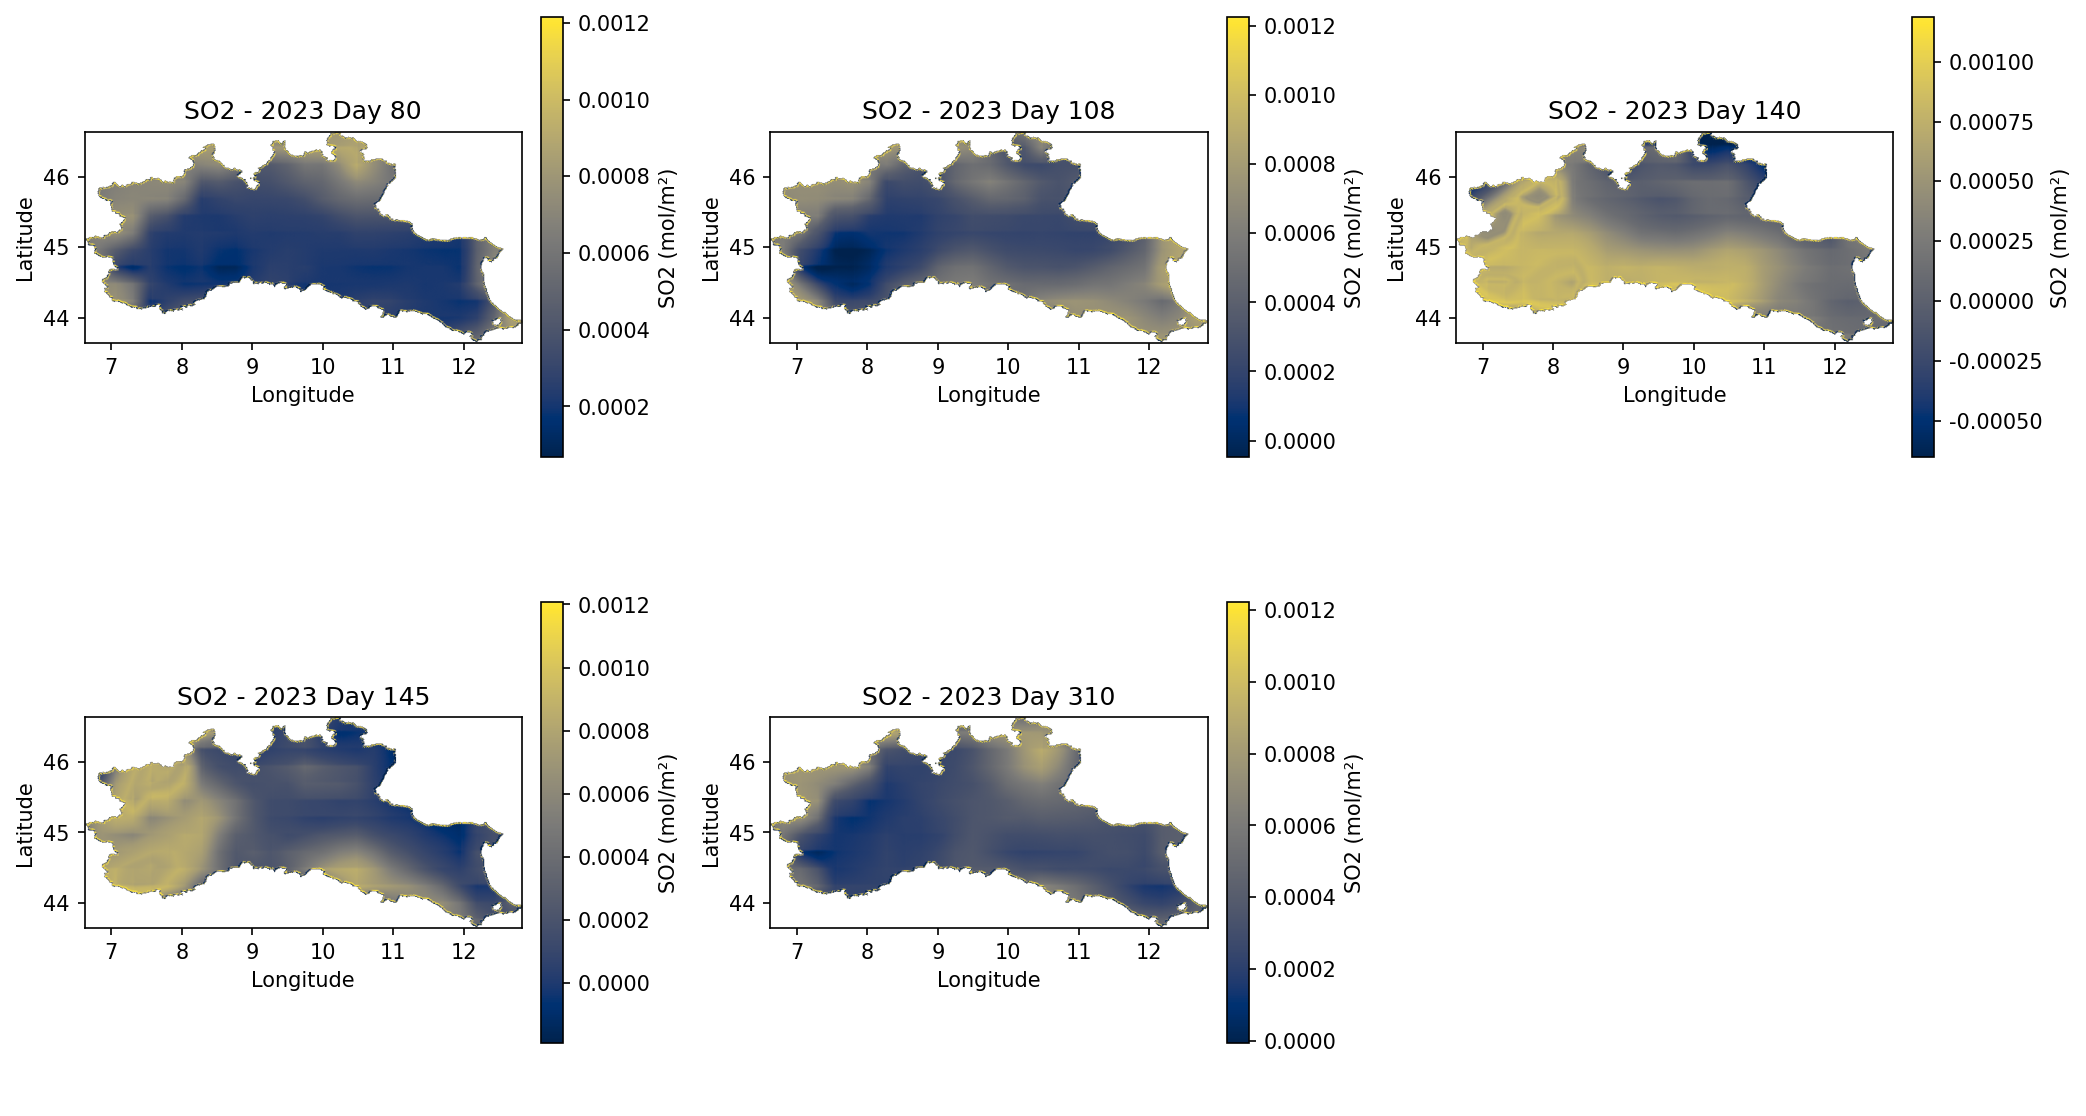

Days plotted: [80, 108, 140, 145, 310]


In [ ]:
# ========= SO2随机可视化5天（与NO2完全一致的格式）=========
import numpy as np, matplotlib.pyplot as plt, rasterio, geopandas as gpd, random
from rasterio.mask import mask

# SO2文件路径
TIF = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_pred_2023_stack.tif"
AOI_SHP = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"
NUM = 5

# 读取AOI
aoi = gpd.read_file(AOI_SHP)

# 读取SO2数据
with rasterio.open(TIF) as ds:
    total = ds.count
    bands = sorted(random.sample(range(1, total + 1), NUM))
    aoi_reproj = aoi.to_crs(ds.crs)

    print(f"SO2数据信息:")
    print(f"  总波段数: {total}")
    print(f"  空间尺寸: {ds.width} x {ds.height}")
    print(f"  坐标系: {ds.crs}")
    print(f"  数据类型: {ds.dtypes[0]}")
    print(f"  随机选择的5天: {bands}")

# 创建子图
ncols, nrows = 3, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 8), dpi=150)
axes = axes.ravel()

# 修复：使用与NO2完全一致的设置
plt.rcParams['font.family'] = 'DejaVu Sans'  # 使用英文字体，避免乱码
plt.rcParams['axes.unicode_minus'] = False

for i, b in enumerate(bands):
    with rasterio.open(TIF) as ds:
        # 用 nodata=np.nan，AOI外为NaN；filled=True 返回普通ndarray
        clipped, trans = mask(
            ds, aoi_reproj.geometry, crop=True,
            nodata=np.nan, filled=True, indexes=b
        )

    # clipped 形状可能是 (1,H,W) 或 (H,W)，统一 squeeze
    arr = np.squeeze(clipped).astype(np.float32)

    # 稳健计算 extent（避免 array_bounds 的元组维度问题）
    h, w = arr.shape
    # Affine 变换：左上与右下角
    left, top = trans * (0, 0)
    right, bottom = trans * (w, h)
    extent = [left, right, bottom, top]

    valid = np.isfinite(arr)
    if valid.sum() == 0:
        # 整幅为空则跳过
        ax = axes[i]
        ax.set_title(f"SO2 - 2023 Day {b} (no valid pixels)")
        ax.axis("off")
        continue

    # 1–99 分位数裁剪，避免极端值主导
    vmin = float(np.percentile(arr[valid], 1))
    vmax = float(np.percentile(arr[valid], 99))
    if vmax <= vmin:
        vmax = vmin + 1e-12

    ax = axes[i]
    masked_arr = np.ma.masked_where(~valid, arr)
    # 修复：使用与NO2完全一致的colormap
    im = ax.imshow(masked_arr, cmap="cividis", vmin=vmin, vmax=vmax,
                   extent=extent, origin="upper")
    # 修复：使用与NO2完全一致的标题格式
    ax.set_title(f"SO2 - 2023 Day {b}")
    # 修复：使用与NO2完全一致的轴标签
    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # 修复：使用与NO2完全一致的颜色条标签
    cbar.set_label("SO2 (mol/m²)")

# 隐藏多余子图
for j in range(i + 1, nrows * ncols):
    axes[j].axis("off")

plt.tight_layout()
plt.show()
print("Days plotted:", bands)

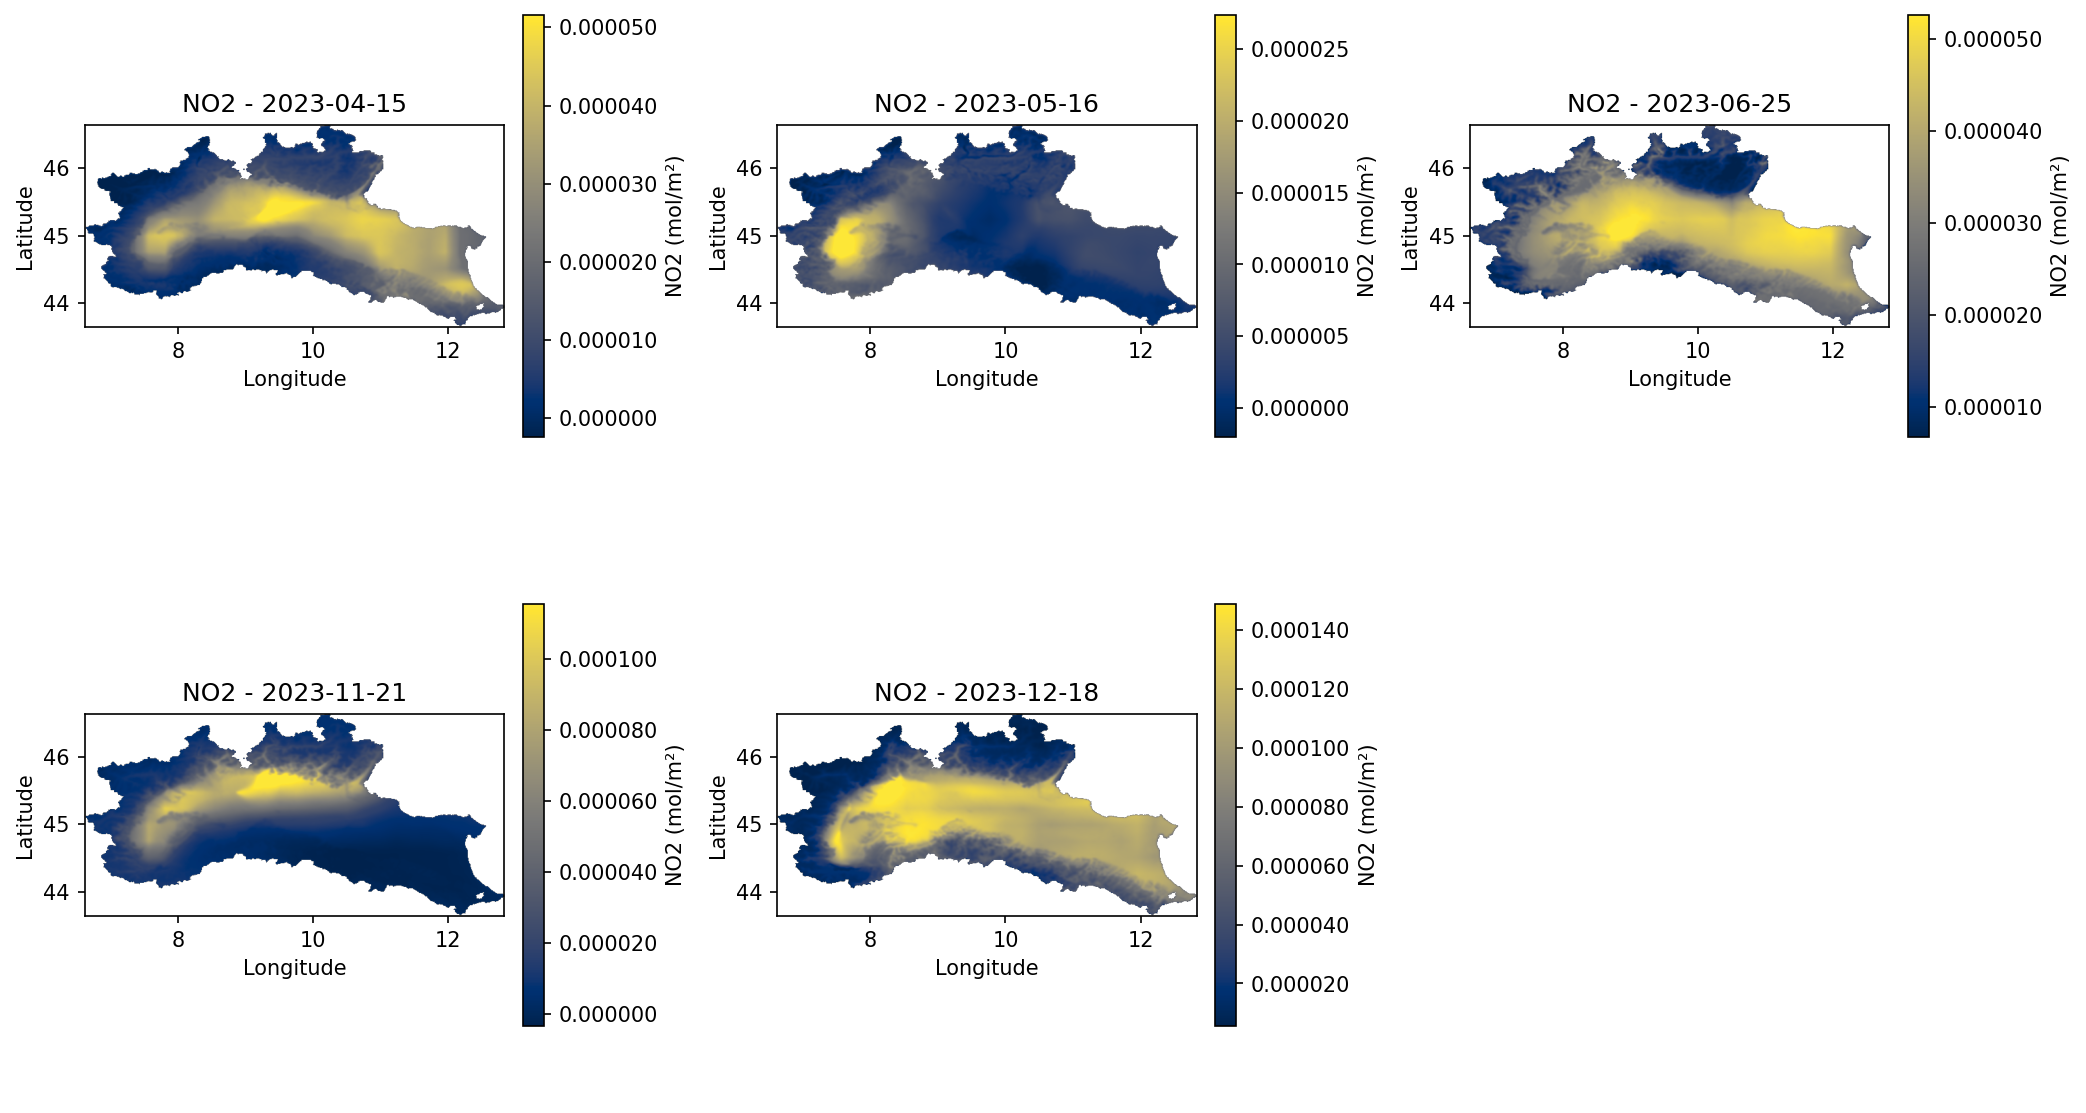

Days plotted: [105, 136, 176, 325, 352]


In [ ]:
# ========= NO2随机可视化5天（稳健extent & AOI外透明，数值单位显示小数点）=========
import numpy as np, matplotlib.pyplot as plt, rasterio, geopandas as gpd, random
from rasterio.mask import mask
from datetime import datetime, timedelta  # 导入datetime和timedelta用于日期计算

TIF = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/no2_pred_2023_stack.tif"
AOI_SHP = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"
NUM = 5

aoi = gpd.read_file(AOI_SHP)

with rasterio.open(TIF) as ds:
    total = ds.count
    bands = sorted(random.sample(range(1, total + 1), NUM))
    aoi_reproj = aoi.to_crs(ds.crs)

ncols, nrows = 3, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 8), dpi=150)
axes = axes.ravel()

# 2023年是测试集，从1月1日开始
start_date_2023 = datetime(2023, 1, 1)

for i, b in enumerate(bands):
    with rasterio.open(TIF) as ds:
        # 用 nodata=np.nan，AOI外为NaN；filled=True 返回普通ndarray
        clipped, trans = mask(
            ds, aoi_reproj.geometry, crop=True,
            nodata=np.nan, filled=True, indexes=b
        )
    # clipped 形状可能是 (1,H,W) 或 (H,W)，统一 squeeze
    arr = np.squeeze(clipped).astype(np.float32)

    # 稳健计算 extent（避免 array_bounds 的元组维度问题）
    h, w = arr.shape
    # Affine 变换：左上与右下角
    left, top = trans * (0, 0)
    right, bottom = trans * (w, h)
    extent = [left, right, bottom, top]

    valid = np.isfinite(arr)
    if valid.sum() == 0:
        # 整幅为空则跳过
        ax = axes[i]
        ax.set_title(f"NO2 - 2023 Day {b} (no valid pixels)")
        ax.axis("off")
        continue

    # 1–99 分位数裁剪，避免极端值主导
    vmin = float(np.percentile(arr[valid], 1))
    vmax = float(np.percentile(arr[valid], 99))
    if vmax <= vmin:
        vmax = vmin + 1e-12

    ax = axes[i]
    masked_arr = np.ma.masked_where(~valid, arr)
    im = ax.imshow(masked_arr, cmap="cividis", vmin=vmin, vmax=vmax,
                   extent=extent, origin="upper")

    # 计算当前波段对应的日期
    current_date = start_date_2023 + timedelta(days=b - 1)
    ax.set_title(f"NO2 - {current_date.strftime('%Y-%m-%d')}")  # 显示日期
    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")

    # 关键修改：添加 format='%.6f' 来显示小数点
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, format='%.6f')
    cbar.set_label("NO2 (mol/m²)")

# 隐藏多余子图
for j in range(i + 1, nrows * ncols):
    axes[j].axis("off")

plt.tight_layout()
plt.show()
print("Days plotted:", bands)

预测数据信息:
  总波段数: 365
  空间尺寸: 621 x 300
  坐标系: EPSG:4326
  随机选择的3天: [21, 158, 187]
原始数据信息:
  总波段数: 365
  空间尺寸: 621 x 300
  坐标系: EPSG:4326


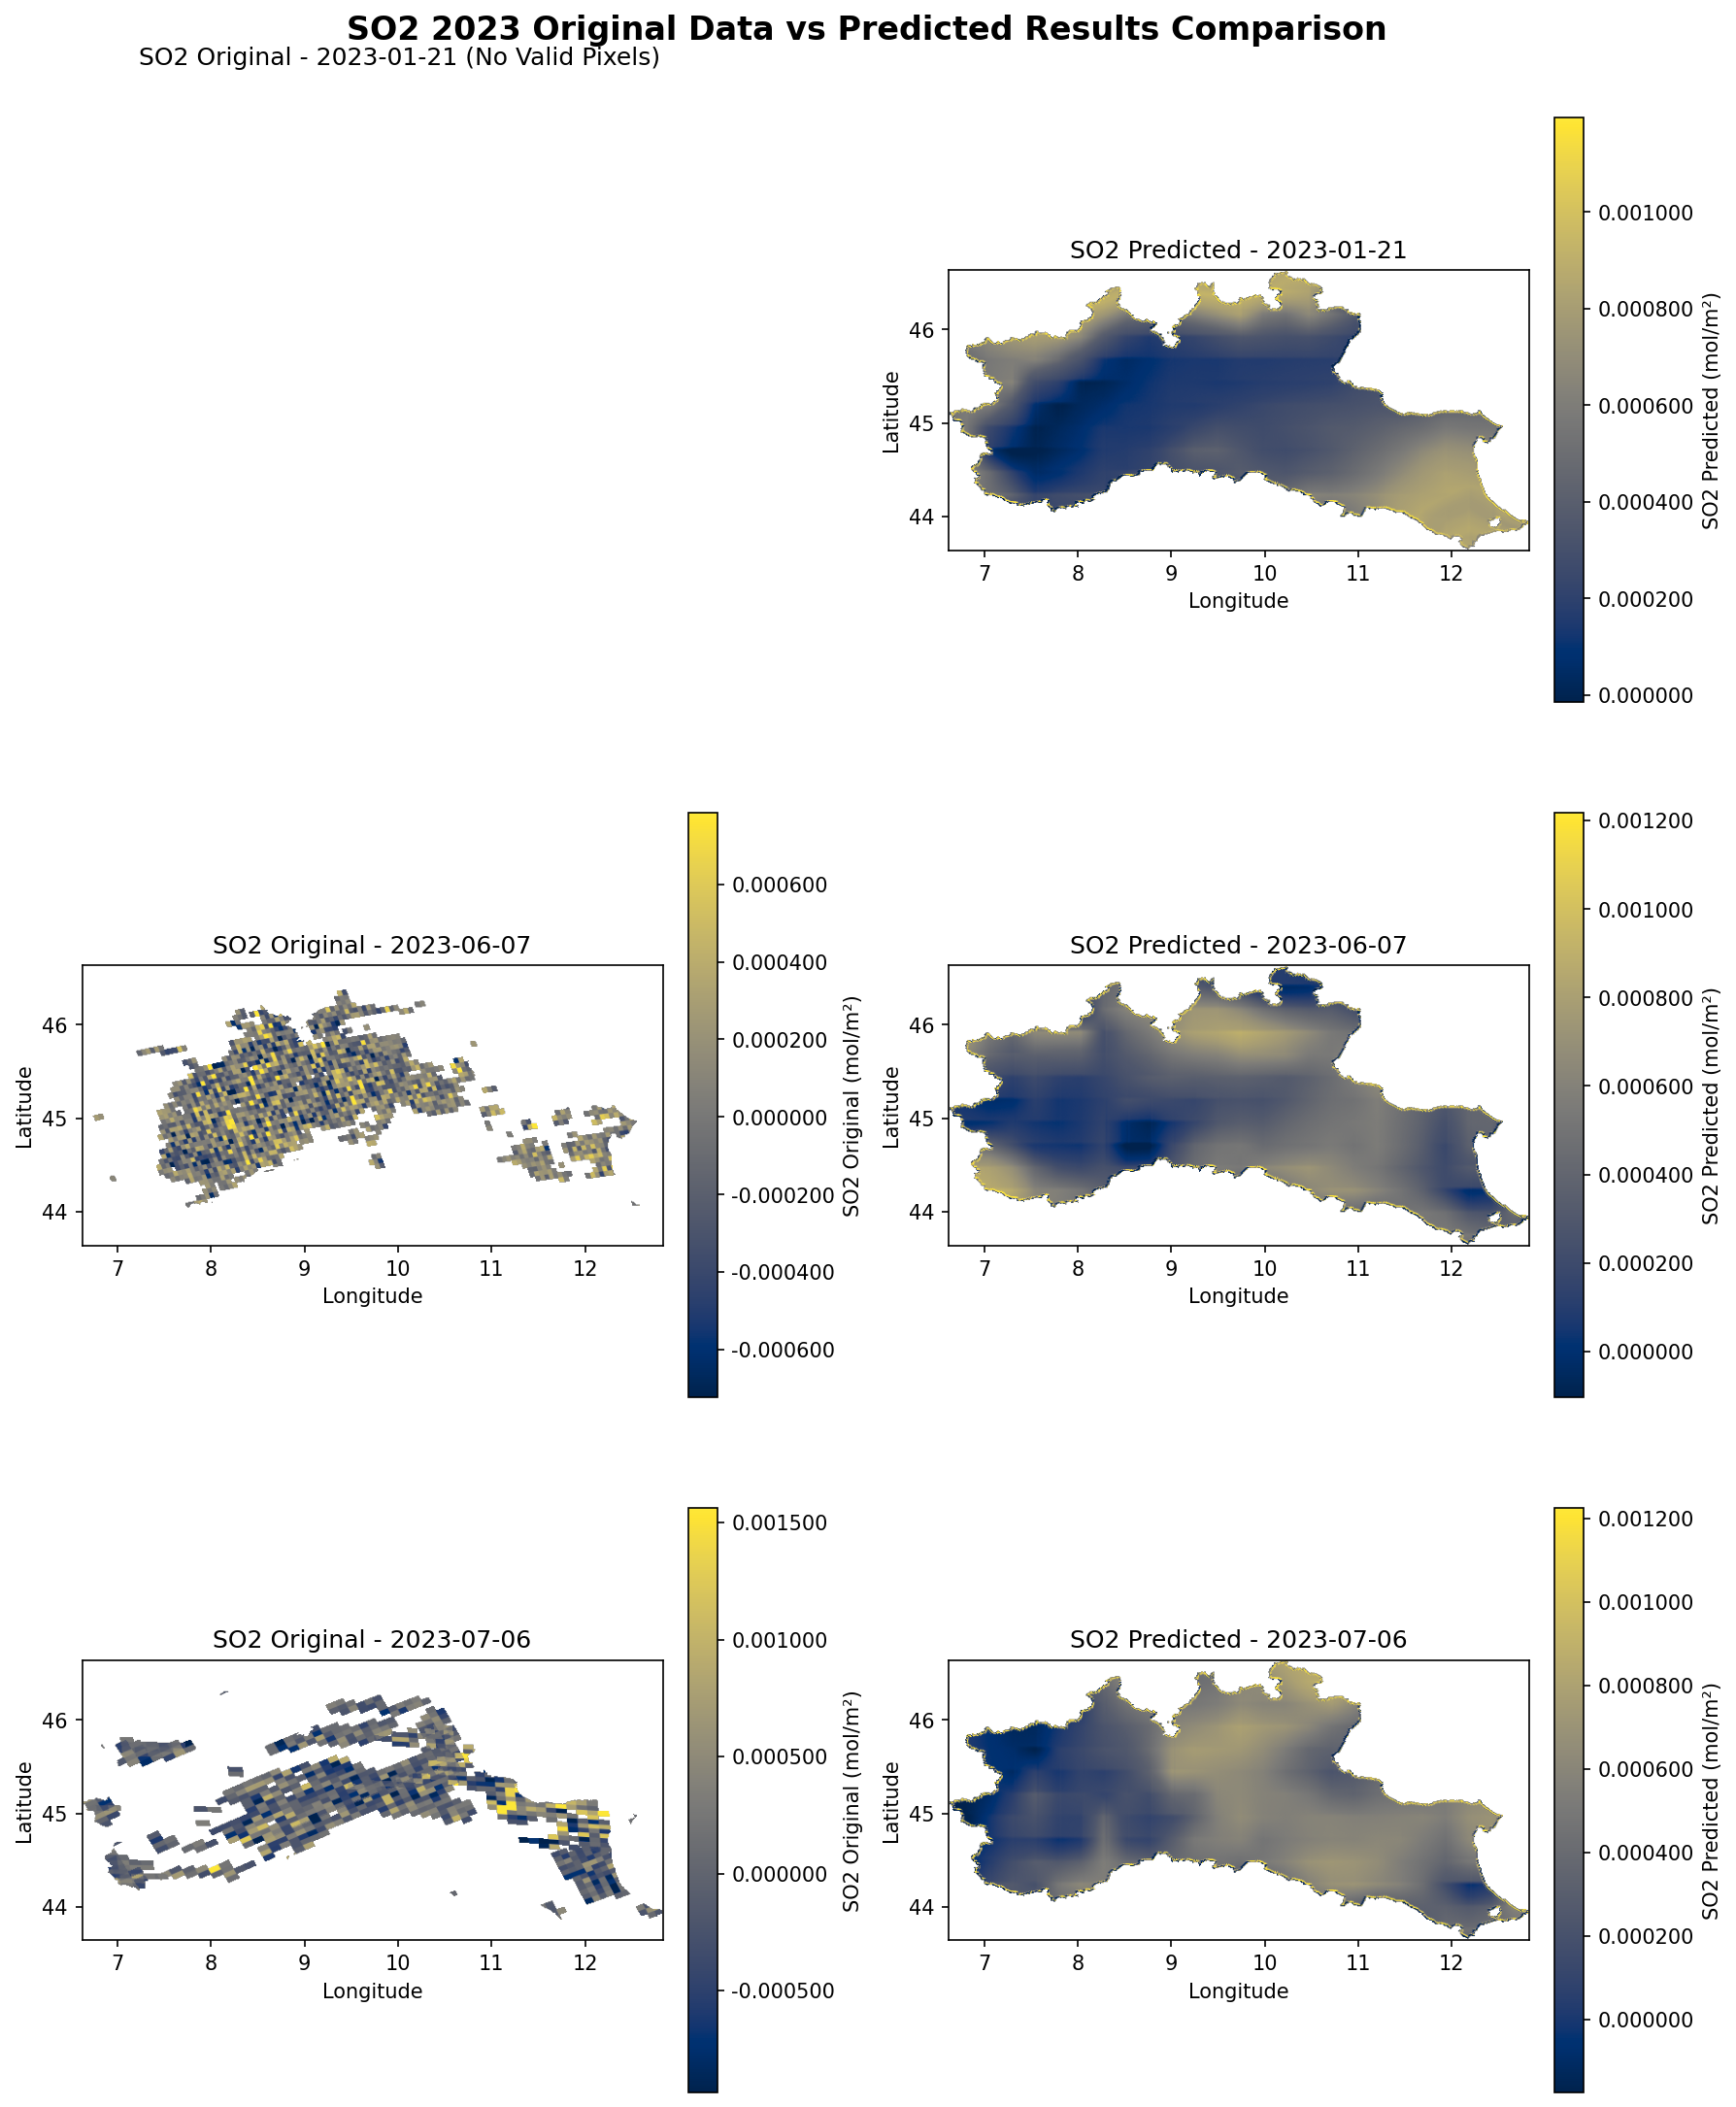

Days plotted: [21, 158, 187]


In [ ]:
# ========= SO2原始数据 vs 预测结果对比可视化（修复版）=========
import numpy as np, matplotlib.pyplot as plt, rasterio, geopandas as gpd, random
from rasterio.mask import mask
from datetime import datetime, timedelta

# 文件路径
PRED_TIF = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_pred_2023_stack.tif"
ORIG_TIF = "/content/drive/MyDrive/GEE_SO2/SO2_Daily_Multiband_2023.tif"  # 2023年原始数据
AOI_SHP = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"
NUM = 3  # 减少到3天，避免索引错误

# 读取AOI
aoi = gpd.read_file(AOI_SHP)

# 读取预测数据
with rasterio.open(PRED_TIF) as ds:
    pred_total = ds.count
    bands = sorted(random.sample(range(1, pred_total + 1), NUM))
    aoi_reproj = aoi.to_crs(ds.crs)

    print(f"预测数据信息:")
    print(f"  总波段数: {pred_total}")
    print(f"  空间尺寸: {ds.width} x {ds.height}")
    print(f"  坐标系: {ds.crs}")
    print(f"  随机选择的3天: {bands}")

# 检查原始数据是否存在
try:
    with rasterio.open(ORIG_TIF) as ds:
        orig_total = ds.count
        print(f"原始数据信息:")
        print(f"  总波段数: {orig_total}")
        print(f"  空间尺寸: {ds.width} x {ds.height}")
        print(f"  坐标系: {ds.crs}")
    has_original = True
except FileNotFoundError:
    print(f"警告: 原始数据文件 {ORIG_TIF} 不存在")
    has_original = False

# 创建子图 (3行2列：每行显示同一天的原始和预测数据)
ncols, nrows = 2, 3  # 2列3行
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 15), dpi=150)

# 修复字体设置，避免乱码
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 2023年起始日期
start_date_2023 = datetime(2023, 1, 1)

for i, b in enumerate(bands):
    # 计算当前日期
    current_date = start_date_2023 + timedelta(days=b - 1)

    # 1. 原始数据（左边）
    ax_orig = axes[i, 0]  # 左列：原始数据

    if not has_original:
        ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')} (Data Not Available)")
        ax_orig.axis("off")
    else:
        try:
            with rasterio.open(ORIG_TIF) as ds:
                clipped_orig, trans_orig = mask(
                    ds, aoi_reproj.geometry, crop=True,
                    nodata=np.nan, filled=True, indexes=b
                )

            arr_orig = np.squeeze(clipped_orig).astype(np.float32)
            h_orig, w_orig = arr_orig.shape
            left_orig, top_orig = trans_orig * (0, 0)
            right_orig, bottom_orig = trans_orig * (w_orig, h_orig)
            extent_orig = [left_orig, right_orig, bottom_orig, top_orig]

            valid_orig = np.isfinite(arr_orig)

            if valid_orig.sum() == 0:
                ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')} (No Valid Pixels)")
                ax_orig.axis("off")
            else:
                vmin_orig = float(np.percentile(arr_orig[valid_orig], 1))
                vmax_orig = float(np.percentile(arr_orig[valid_orig], 99))
                if vmax_orig <= vmin_orig:
                    vmax_orig = vmin_orig + 1e-12

                masked_arr_orig = np.ma.masked_where(~valid_orig, arr_orig)
                im_orig = ax_orig.imshow(masked_arr_orig, cmap="cividis", vmin=vmin_orig, vmax=vmax_orig,
                                        extent=extent_orig, origin="upper")
                ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')}")
                ax_orig.set_xlabel("Longitude"); ax_orig.set_ylabel("Latitude")
                cbar_orig = fig.colorbar(im_orig, ax=ax_orig, fraction=0.046, pad=0.04, format='%.6f')
                cbar_orig.set_label("SO2 Original (mol/m²)")
        except Exception as e:
            ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')} (Error: {str(e)})")
            ax_orig.axis("off")

    # 2. 预测数据（右边）
    ax_pred = axes[i, 1]  # 右列：预测数据

    try:
        with rasterio.open(PRED_TIF) as ds:
            clipped_pred, trans_pred = mask(
                ds, aoi_reproj.geometry, crop=True,
                nodata=np.nan, filled=True, indexes=b
            )

        arr_pred = np.squeeze(clipped_pred).astype(np.float32)
        h_pred, w_pred = arr_pred.shape
        left_pred, top_pred = trans_pred * (0, 0)
        right_pred, bottom_pred = trans_pred * (w_pred, h_pred)
        extent_pred = [left_pred, right_pred, bottom_pred, top_pred]

        valid_pred = np.isfinite(arr_pred)

        if valid_pred.sum() == 0:
            ax_pred.set_title(f"SO2 Predicted - {current_date.strftime('%Y-%m-%d')} (No Valid Pixels)")
            ax_pred.axis("off")
        else:
            vmin_pred = float(np.percentile(arr_pred[valid_pred], 1))
            vmax_pred = float(np.percentile(arr_pred[valid_pred], 99))
            if vmax_pred <= vmin_pred:
                vmax_pred = vmin_pred + 1e-12

            masked_arr_pred = np.ma.masked_where(~valid_pred, arr_pred)
            im_pred = ax_pred.imshow(masked_arr_pred, cmap="cividis", vmin=vmin_pred, vmax=vmax_pred,
                                    extent=extent_pred, origin="upper")
            ax_pred.set_title(f"SO2 Predicted - {current_date.strftime('%Y-%m-%d')}")
            ax_pred.set_xlabel("Longitude"); ax_pred.set_ylabel("Latitude")
            cbar_pred = fig.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04, format='%.6f')
            cbar_pred.set_label("SO2 Predicted (mol/m²)")
    except Exception as e:
        ax_pred.set_title(f"SO2 Predicted - {current_date.strftime('%Y-%m-%d')} (Error: {str(e)})")
        ax_pred.axis("off")

plt.suptitle("SO2 2023 Original Data vs Predicted Results Comparison", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
print("Days plotted:", bands)

预测数据信息:
  总波段数: 365
  空间尺寸: 621 x 300
  坐标系: EPSG:4326
  随机选择的3天: [108, 184, 350]
原始数据信息:
  总波段数: 365
  空间尺寸: 621 x 300
  坐标系: EPSG:4326


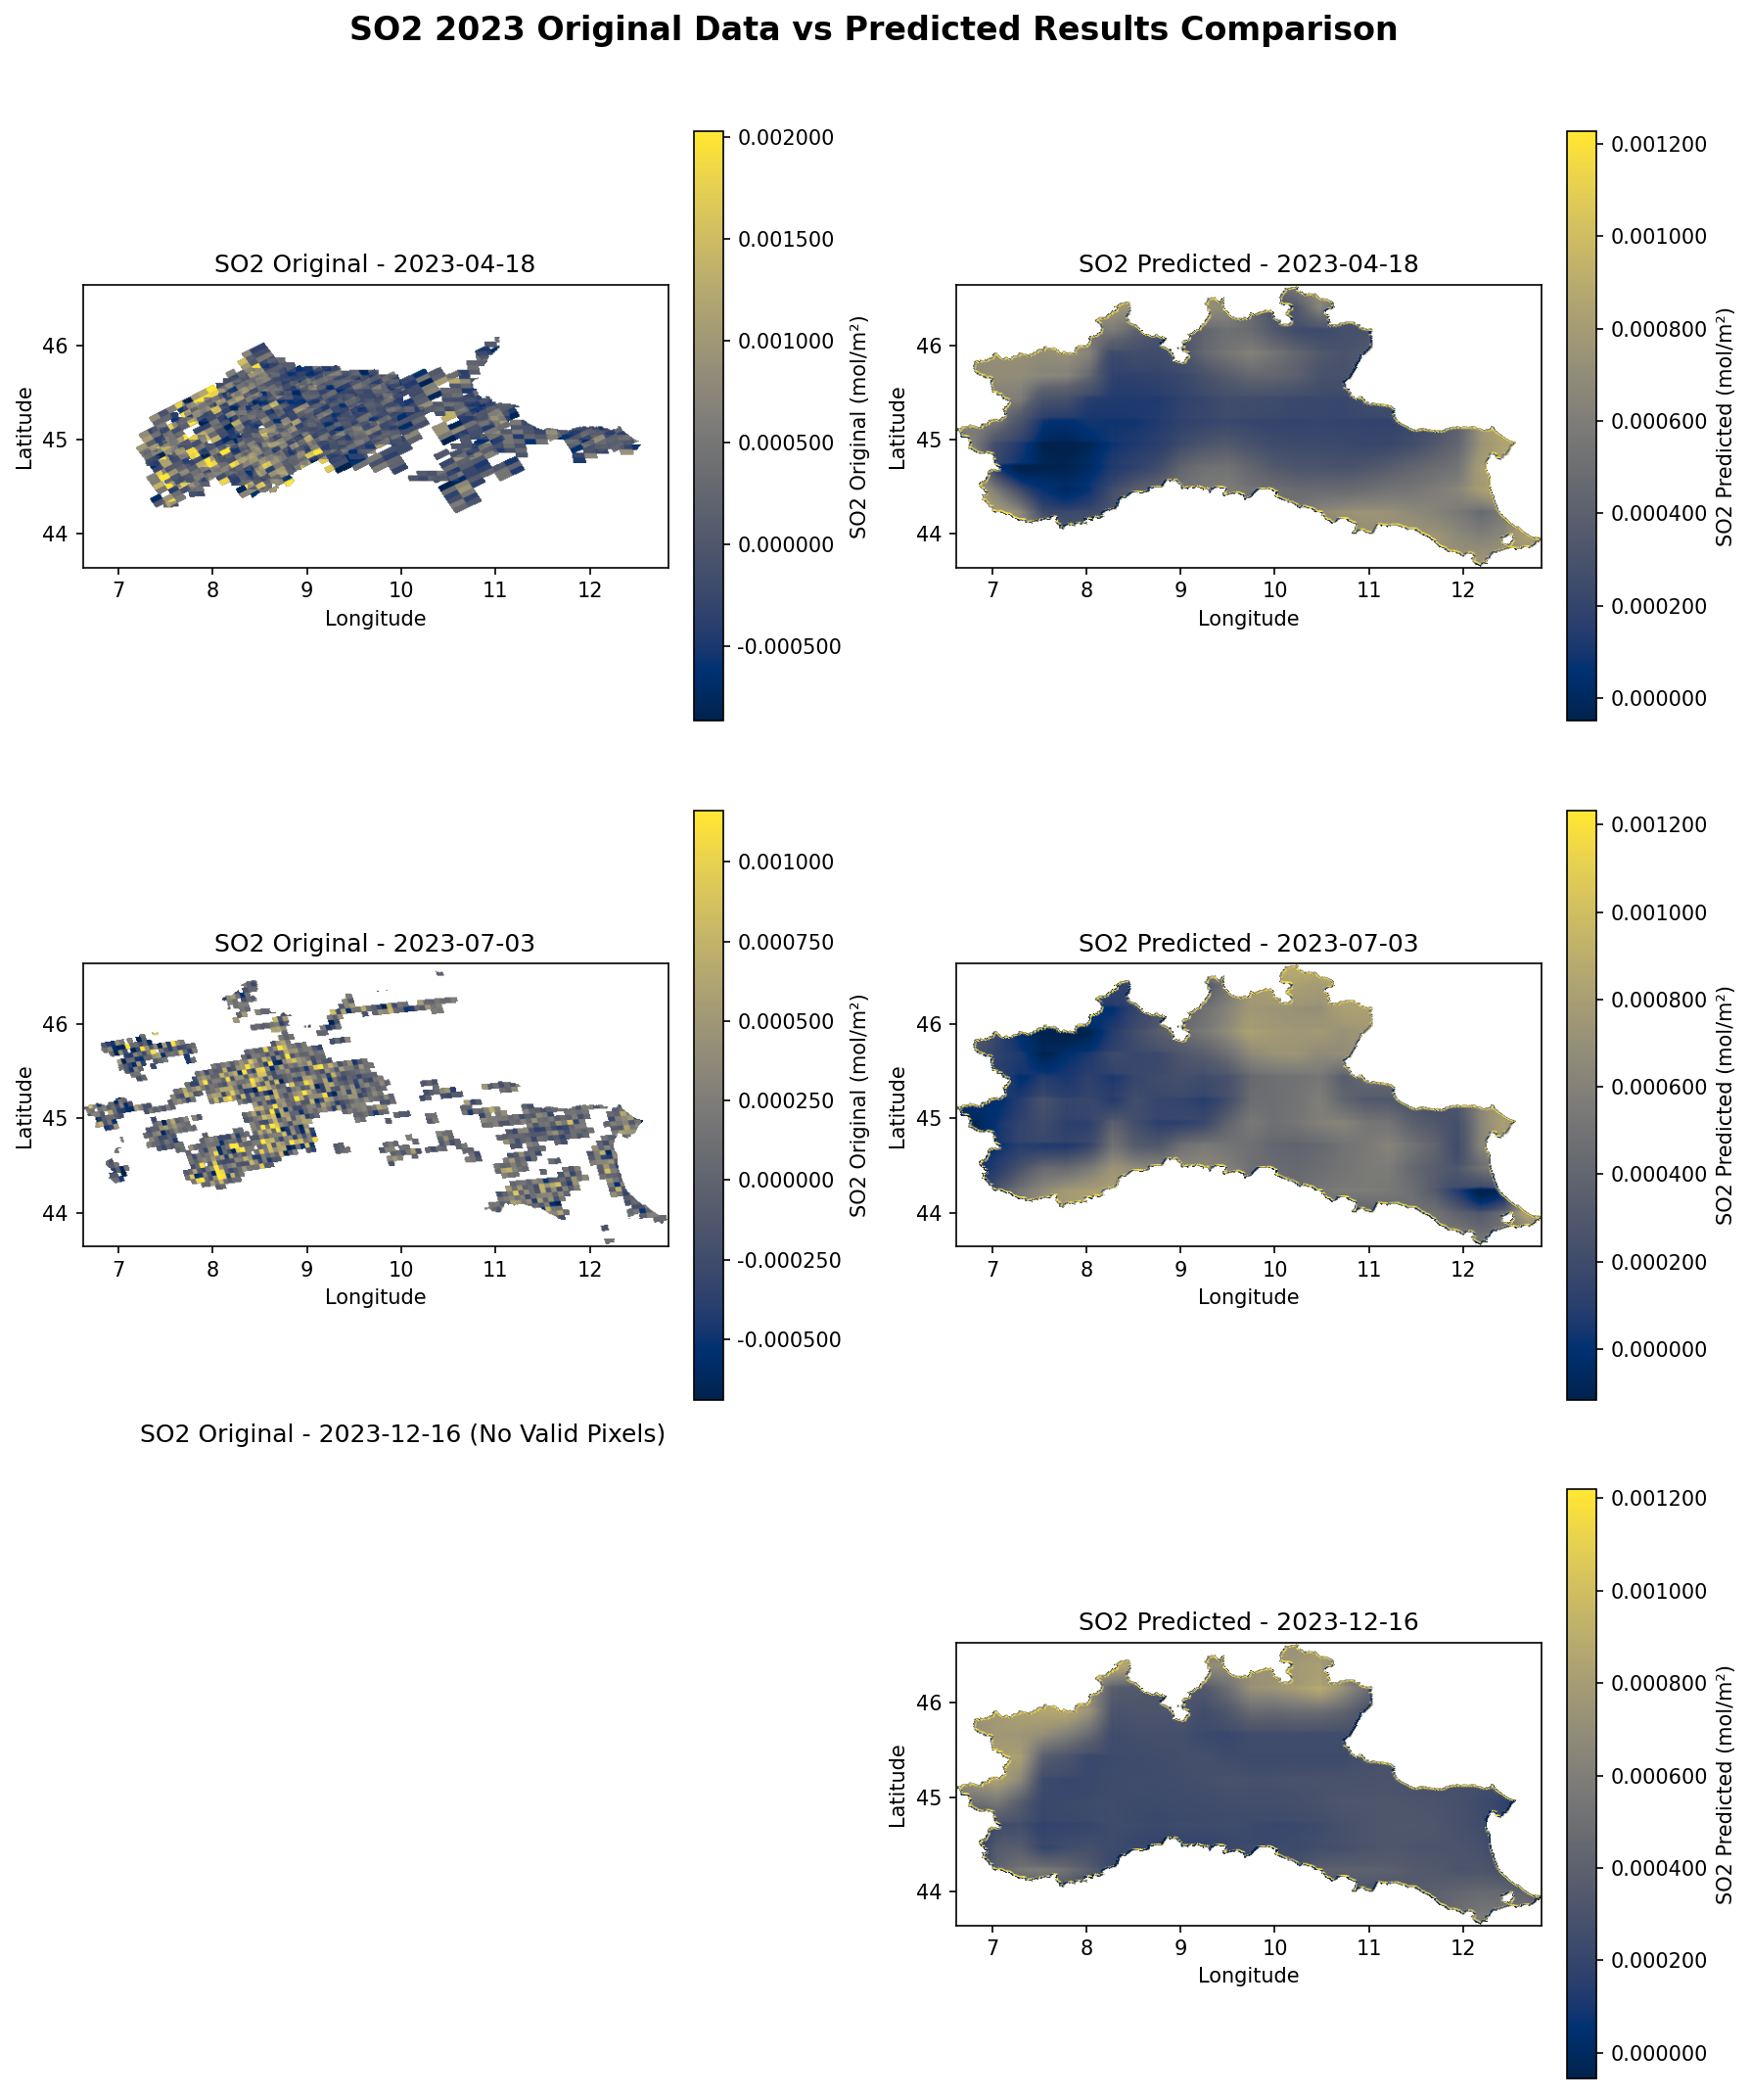

Days plotted: [108, 184, 350]


In [ ]:
# ========= SO2原始数据 vs 预测结果对比可视化（修复标题位置）=========
import numpy as np, matplotlib.pyplot as plt, rasterio, geopandas as gpd, random
from rasterio.mask import mask
from datetime import datetime, timedelta

# 文件路径
PRED_TIF = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_pred_2023_stack.tif"
ORIG_TIF = "/content/drive/MyDrive/GEE_SO2/SO2_Daily_Multiband_2023.tif"  # 2023年原始数据
AOI_SHP = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"
NUM = 3  # 减少到3天，避免索引错误

# 读取AOI
aoi = gpd.read_file(AOI_SHP)

# 读取预测数据
with rasterio.open(PRED_TIF) as ds:
    pred_total = ds.count
    bands = sorted(random.sample(range(1, pred_total + 1), NUM))
    aoi_reproj = aoi.to_crs(ds.crs)

    print(f"预测数据信息:")
    print(f"  总波段数: {pred_total}")
    print(f"  空间尺寸: {ds.width} x {ds.height}")
    print(f"  坐标系: {ds.crs}")
    print(f"  随机选择的3天: {bands}")

# 检查原始数据是否存在
try:
    with rasterio.open(ORIG_TIF) as ds:
        orig_total = ds.count
        print(f"原始数据信息:")
        print(f"  总波段数: {orig_total}")
        print(f"  空间尺寸: {ds.width} x {ds.height}")
        print(f"  坐标系: {ds.crs}")
    has_original = True
except FileNotFoundError:
    print(f"警告: 原始数据文件 {ORIG_TIF} 不存在")
    has_original = False

# 创建子图 (3行2列：每行显示同一天的原始和预测数据)
ncols, nrows = 2, 3  # 2列3行
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 15), dpi=150)

# 修复字体设置，避免乱码
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 2023年起始日期
start_date_2023 = datetime(2023, 1, 1)

for i, b in enumerate(bands):
    # 计算当前日期
    current_date = start_date_2023 + timedelta(days=b - 1)

    # 1. 原始数据（左边）
    ax_orig = axes[i, 0]  # 左列：原始数据

    if not has_original:
        # 设置标题位置，避免与主标题太近
        ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')} (Data Not Available)",
                         pad=20, fontsize=12)
        ax_orig.axis("off")
    else:
        try:
            with rasterio.open(ORIG_TIF) as ds:
                clipped_orig, trans_orig = mask(
                    ds, aoi_reproj.geometry, crop=True,
                    nodata=np.nan, filled=True, indexes=b
                )

            arr_orig = np.squeeze(clipped_orig).astype(np.float32)
            h_orig, w_orig = arr_orig.shape
            left_orig, top_orig = trans_orig * (0, 0)
            right_orig, bottom_orig = trans_orig * (w_orig, h_orig)
            extent_orig = [left_orig, right_orig, bottom_orig, top_orig]

            valid_orig = np.isfinite(arr_orig)

            if valid_orig.sum() == 0:
                # 设置标题位置，避免与主标题太近
                ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')} (No Valid Pixels)",
                                 pad=20, fontsize=12)
                ax_orig.axis("off")
            else:
                vmin_orig = float(np.percentile(arr_orig[valid_orig], 1))
                vmax_orig = float(np.percentile(arr_orig[valid_orig], 99))
                if vmax_orig <= vmin_orig:
                    vmax_orig = vmin_orig + 1e-12

                masked_arr_orig = np.ma.masked_where(~valid_orig, arr_orig)
                im_orig = ax_orig.imshow(masked_arr_orig, cmap="cividis", vmin=vmin_orig, vmax=vmax_orig,
                                        extent=extent_orig, origin="upper")
                ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')}")
                ax_orig.set_xlabel("Longitude"); ax_orig.set_ylabel("Latitude")
                cbar_orig = fig.colorbar(im_orig, ax=ax_orig, fraction=0.046, pad=0.04, format='%.6f')
                cbar_orig.set_label("SO2 Original (mol/m²)")
        except Exception as e:
            # 设置标题位置，避免与主标题太近
            ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')} (Error: {str(e)})",
                             pad=20, fontsize=12)
            ax_orig.axis("off")

    # 2. 预测数据（右边）
    ax_pred = axes[i, 1]  # 右列：预测数据

    try:
        with rasterio.open(PRED_TIF) as ds:
            clipped_pred, trans_pred = mask(
                ds, aoi_reproj.geometry, crop=True,
                nodata=np.nan, filled=True, indexes=b
            )

        arr_pred = np.squeeze(clipped_pred).astype(np.float32)
        h_pred, w_pred = arr_pred.shape
        left_pred, top_pred = trans_pred * (0, 0)
        right_pred, bottom_pred = trans_pred * (w_pred, h_pred)
        extent_pred = [left_pred, right_pred, bottom_pred, top_pred]

        valid_pred = np.isfinite(arr_pred)

        if valid_pred.sum() == 0:
            # 设置标题位置，避免与主标题太近
            ax_pred.set_title(f"SO2 Predicted - {current_date.strftime('%Y-%m-%d')} (No Valid Pixels)",
                             pad=20, fontsize=12)
            ax_pred.axis("off")
        else:
            vmin_pred = float(np.percentile(arr_pred[valid_pred], 1))
            vmax_pred = float(np.percentile(arr_pred[valid_pred], 99))
            if vmax_pred <= vmin_pred:
                vmax_pred = vmin_pred + 1e-12

            masked_arr_pred = np.ma.masked_where(~valid_pred, arr_pred)
            im_pred = ax_pred.imshow(masked_arr_pred, cmap="cividis", vmin=vmin_pred, vmax=vmax_pred,
                                    extent=extent_pred, origin="upper")
            ax_pred.set_title(f"SO2 Predicted - {current_date.strftime('%Y-%m-%d')}")
            ax_pred.set_xlabel("Longitude"); ax_pred.set_ylabel("Latitude")
            cbar_pred = fig.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04, format='%.6f')
            cbar_pred.set_label("SO2 Predicted (mol/m²)")
    except Exception as e:
        # 设置标题位置，避免与主标题太近
        ax_pred.set_title(f"SO2 Predicted - {current_date.strftime('%Y-%m-%d')} (Error: {str(e)})",
                         pad=20, fontsize=12)
        ax_pred.axis("off")

# 设置主标题，增加与子图标题的间距
plt.suptitle("SO2 2023 Original Data vs Predicted Results Comparison",
             fontsize=16, fontweight='bold', y=0.95)

# 调整布局，增加子图间距
plt.tight_layout()
plt.subplots_adjust(top=0.90)  # 为主标题留出更多空间
plt.show()
print("Days plotted:", bands)

NO2预测数据信息:
  总波段数: 365
  空间尺寸: 621 x 300
  坐标系: EPSG:4326
  随机选择的3天: [22, 66, 221]
NO2原始数据信息:
  总波段数: 365
  空间尺寸: 621 x 300
  坐标系: EPSG:4326


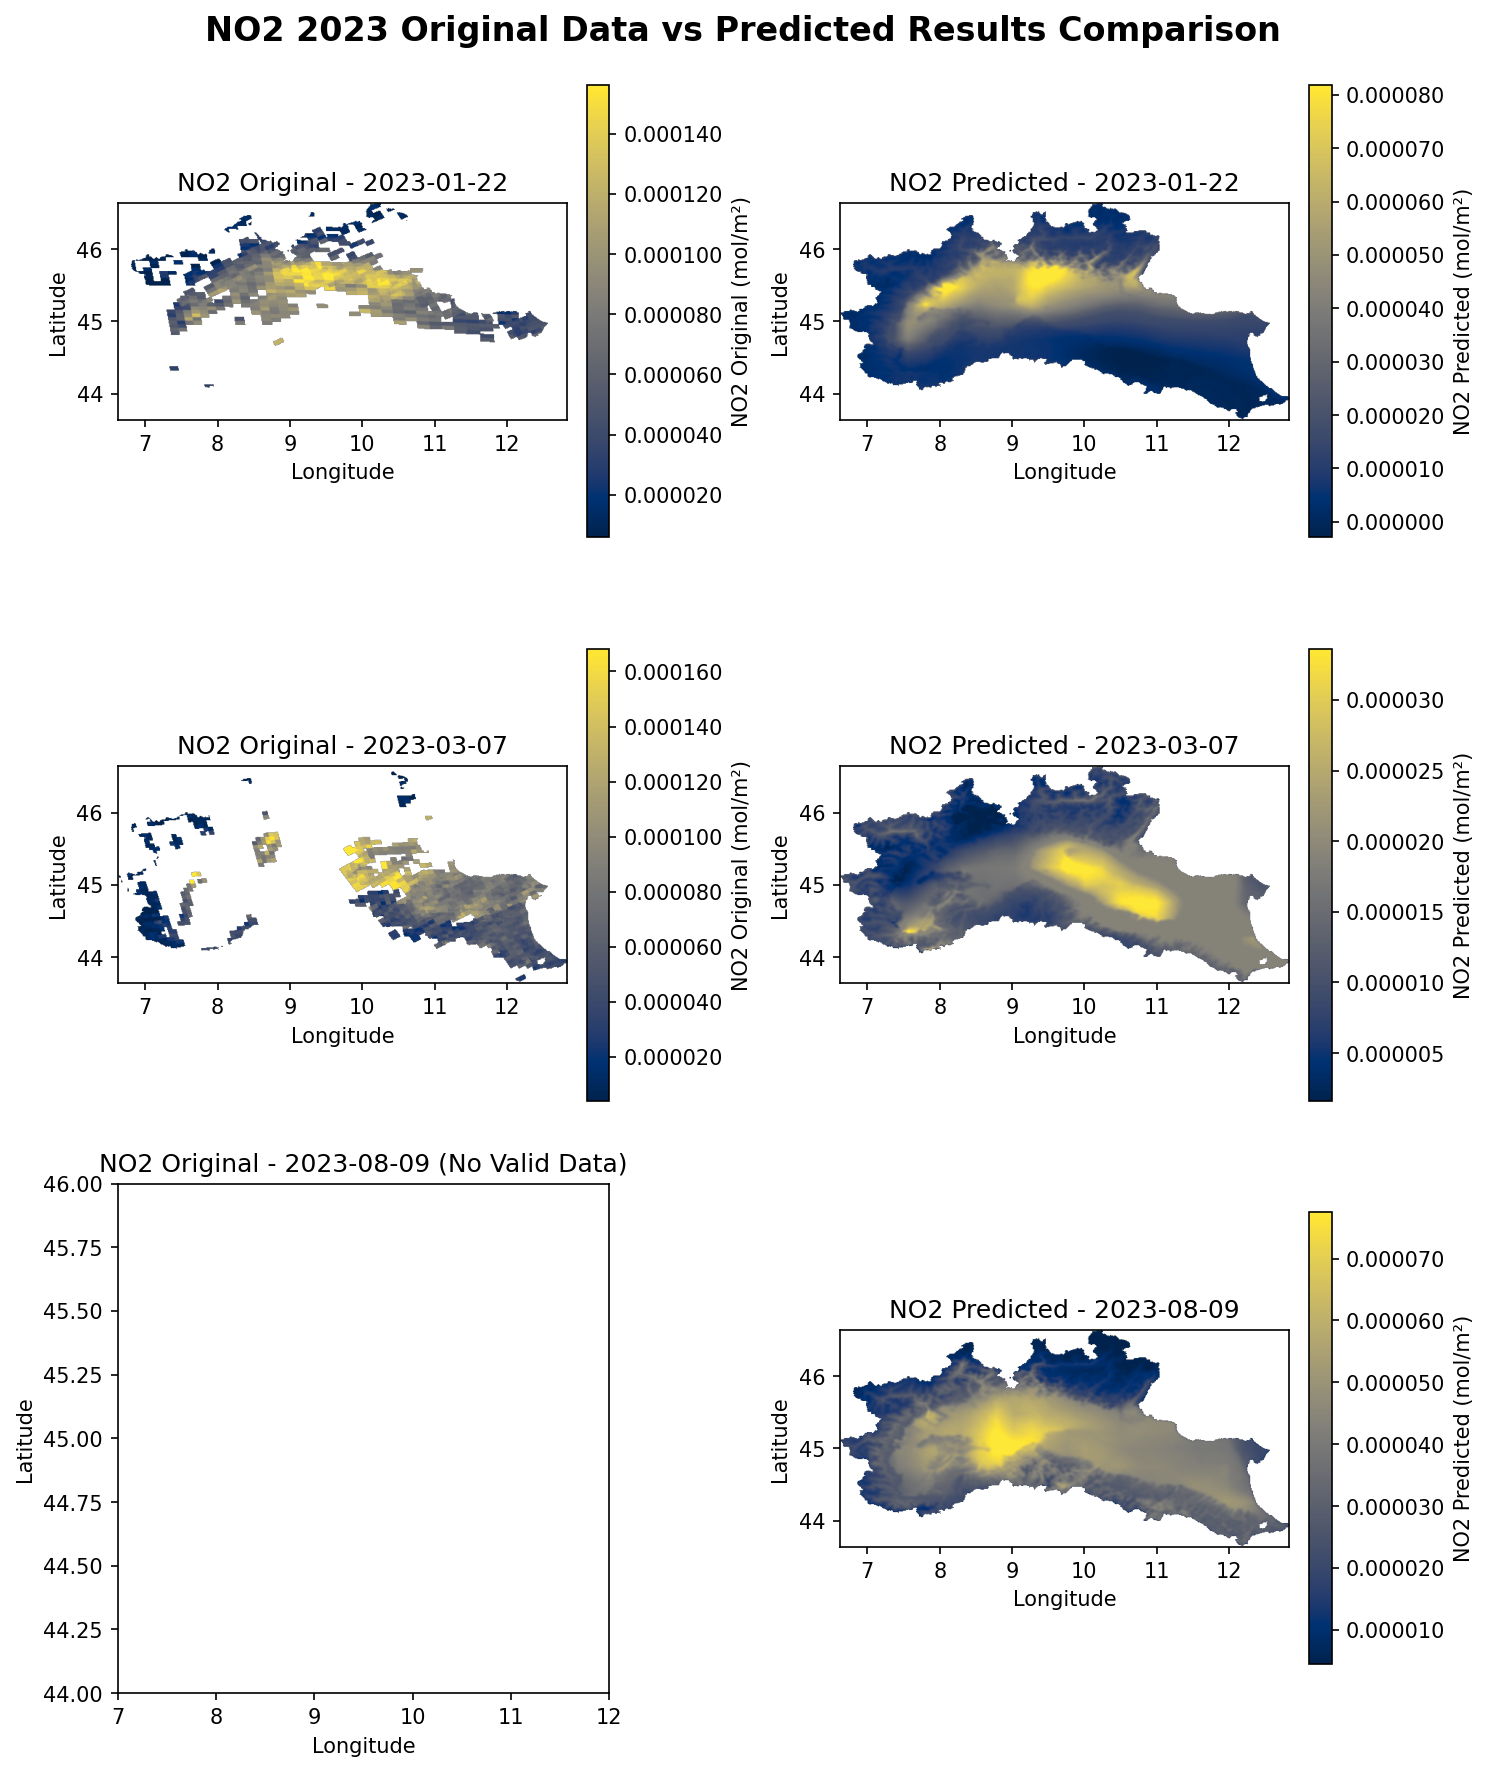

Days plotted: [22, 66, 221]


In [ ]:
# ========= NO2原始数据 vs 预测结果对比可视化 =========
import numpy as np, matplotlib.pyplot as plt, rasterio, geopandas as gpd, random
from rasterio.mask import mask
from datetime import datetime, timedelta

# 文件路径
PRED_TIF = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/no2_pred_2023_stack.tif"
ORIG_TIF = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2023.tif"  # 2023年原始数据
AOI_SHP = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"
NUM = 3

# 读取AOI
aoi = gpd.read_file(AOI_SHP)

# 读取预测数据
with rasterio.open(PRED_TIF) as ds:
    pred_total = ds.count
    bands = sorted(random.sample(range(1, pred_total + 1), NUM))
    aoi_reproj = aoi.to_crs(ds.crs)

    print(f"NO2预测数据信息:")
    print(f"  总波段数: {pred_total}")
    print(f"  空间尺寸: {ds.width} x {ds.height}")
    print(f"  坐标系: {ds.crs}")
    print(f"  随机选择的3天: {bands}")

# 检查原始数据
try:
    with rasterio.open(ORIG_TIF) as ds:
        orig_total = ds.count
        print(f"NO2原始数据信息:")
        print(f"  总波段数: {orig_total}")
        print(f"  空间尺寸: {ds.width} x {ds.height}")
        print(f"  坐标系: {ds.crs}")
    has_original = True
except FileNotFoundError:
    print("NO2原始数据文件不存在，只显示预测数据")
    has_original = False

# 创建子图 (3行2列：每行显示同一天的原始和预测数据)
ncols, nrows = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 12), dpi=150)

# 设置字体
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 2023年起始日期
start_date_2023 = datetime(2023, 1, 1)

for i, b in enumerate(bands):
    current_date = start_date_2023 + timedelta(days=b - 1)

    # 1. 原始数据（左边）
    ax_orig = axes[i, 0]

    if not has_original:
        # 完全空白的图，只显示标题和坐标轴
        ax_orig.set_title(f"NO2 Original - {current_date.strftime('%Y-%m-%d')} (No Data Available)")
        ax_orig.set_xlabel("Longitude"); ax_orig.set_ylabel("Latitude")
        # 设置坐标范围，但不显示任何内容
        ax_orig.set_xlim(7, 12)
        ax_orig.set_ylim(44, 46)
        ax_orig.set_facecolor('white')
    else:
        try:
            with rasterio.open(ORIG_TIF) as ds:
                clipped_orig, trans_orig = mask(
                    ds, aoi_reproj.geometry, crop=True,
                    nodata=np.nan, filled=True, indexes=b
                )

            arr_orig = np.squeeze(clipped_orig).astype(np.float32)
            valid_orig = np.isfinite(arr_orig)

            if valid_orig.sum() == 0:
                # 完全空白的图，只显示标题和坐标轴
                ax_orig.set_title(f"NO2 Original - {current_date.strftime('%Y-%m-%d')} (No Valid Data)")
                ax_orig.set_xlabel("Longitude"); ax_orig.set_ylabel("Latitude")
                # 设置坐标范围，但不显示任何内容
                ax_orig.set_xlim(7, 12)
                ax_orig.set_ylim(44, 46)
                ax_orig.set_facecolor('white')
            else:
                h_orig, w_orig = arr_orig.shape
                left_orig, top_orig = trans_orig * (0, 0)
                right_orig, bottom_orig = trans_orig * (w_orig, h_orig)
                extent_orig = [left_orig, right_orig, bottom_orig, top_orig]

                vmin_orig = float(np.percentile(arr_orig[valid_orig], 1))
                vmax_orig = float(np.percentile(arr_orig[valid_orig], 99))
                if vmax_orig <= vmin_orig:
                    vmax_orig = vmin_orig + 1e-12

                masked_arr_orig = np.ma.masked_where(~valid_orig, arr_orig)
                im_orig = ax_orig.imshow(masked_arr_orig, cmap="cividis", vmin=vmin_orig, vmax=vmax_orig,
                                        extent=extent_orig, origin="upper")
                ax_orig.set_title(f"NO2 Original - {current_date.strftime('%Y-%m-%d')}")
                ax_orig.set_xlabel("Longitude"); ax_orig.set_ylabel("Latitude")
                cbar_orig = fig.colorbar(im_orig, ax=ax_orig, fraction=0.046, pad=0.04, format='%.6f')
                cbar_orig.set_label("NO2 Original (mol/m²)")
        except Exception as e:
            # 完全空白的图，只显示标题和坐标轴
            ax_orig.set_title(f"NO2 Original - {current_date.strftime('%Y-%m-%d')} (Error)")
            ax_orig.set_xlabel("Longitude"); ax_orig.set_ylabel("Latitude")
            # 设置坐标范围，但不显示任何内容
            ax_orig.set_xlim(7, 12)
            ax_orig.set_ylim(44, 46)
            ax_orig.set_facecolor('white')

    # 2. 预测数据（右边）
    ax_pred = axes[i, 1]

    try:
        with rasterio.open(PRED_TIF) as ds:
            clipped_pred, trans_pred = mask(
                ds, aoi_reproj.geometry, crop=True,
                nodata=np.nan, filled=True, indexes=b
            )

        arr_pred = np.squeeze(clipped_pred).astype(np.float32)
        valid_pred = np.isfinite(arr_pred)

        h_pred, w_pred = arr_pred.shape
        left_pred, top_pred = trans_pred * (0, 0)
        right_pred, bottom_pred = trans_pred * (w_pred, h_pred)
        extent_pred = [left_pred, right_pred, bottom_pred, top_pred]

        vmin_pred = float(np.percentile(arr_pred[valid_pred], 1))
        vmax_pred = float(np.percentile(arr_pred[valid_pred], 99))
        if vmax_pred <= vmin_pred:
            vmax_pred = vmin_pred + 1e-12

        masked_arr_pred = np.ma.masked_where(~valid_pred, arr_pred)
        im_pred = ax_pred.imshow(masked_arr_pred, cmap="cividis", vmin=vmin_pred, vmax=vmax_pred,
                                extent=extent_pred, origin="upper")
        ax_pred.set_title(f"NO2 Predicted - {current_date.strftime('%Y-%m-%d')}")
        ax_pred.set_xlabel("Longitude"); ax_pred.set_ylabel("Latitude")
        cbar_pred = fig.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04, format='%.6f')
        cbar_pred.set_label("NO2 Predicted (mol/m²)")
    except Exception as e:
        ax_pred.set_title(f"NO2 Predicted - {current_date.strftime('%Y-%m-%d')} (Error)")
        ax_pred.axis("off")

plt.suptitle("NO2 2023 Original Data vs Predicted Results Comparison", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
print("Days plotted:", bands)

NO2预测数据信息:
  总波段数: 365
  空间尺寸: 621 x 300
  坐标系: EPSG:4326
  随机选择的3天: [53, 128, 342]
NO2原始数据信息:
  总波段数: 365
  空间尺寸: 621 x 300
  坐标系: EPSG:4326


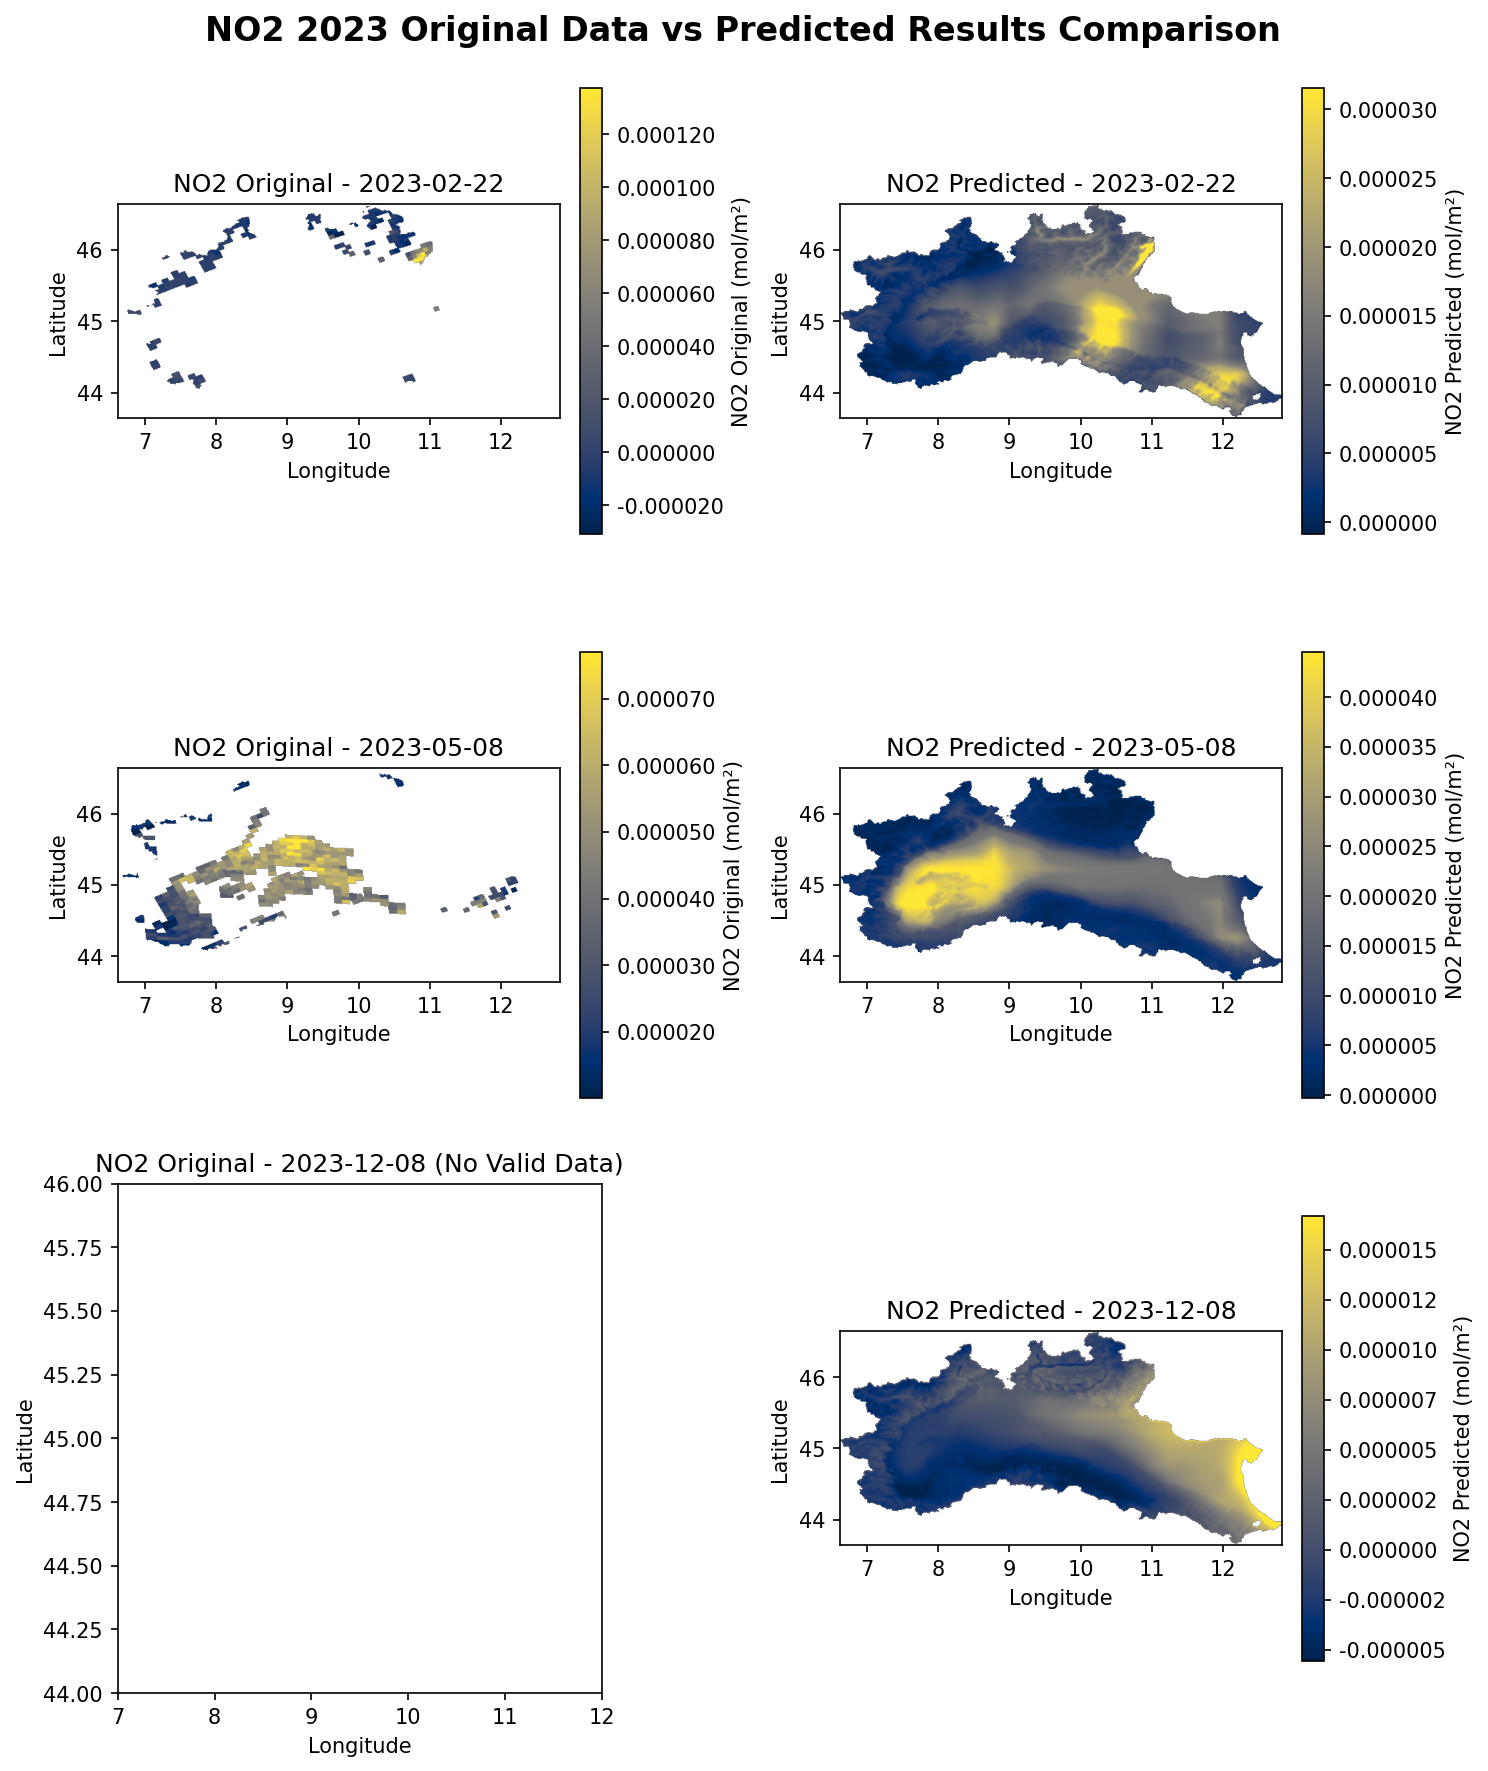

Days plotted: [53, 128, 342]


In [ ]:
# ========= NO2原始数据 vs 预测结果对比可视化 =========
import numpy as np, matplotlib.pyplot as plt, rasterio, geopandas as gpd, random
from rasterio.mask import mask
from datetime import datetime, timedelta

# 文件路径
PRED_TIF = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/no2_pred_2023_stack.tif"
ORIG_TIF = "/content/drive/MyDrive/GEE_NO2/NO2_Daily_Multiband_2023.tif"  # 2023年原始数据
AOI_SHP = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"
NUM = 3

# 读取AOI
aoi = gpd.read_file(AOI_SHP)

# 读取预测数据
with rasterio.open(PRED_TIF) as ds:
    pred_total = ds.count
    bands = sorted(random.sample(range(1, pred_total + 1), NUM))
    aoi_reproj = aoi.to_crs(ds.crs)

    print(f"NO2预测数据信息:")
    print(f"  总波段数: {pred_total}")
    print(f"  空间尺寸: {ds.width} x {ds.height}")
    print(f"  坐标系: {ds.crs}")
    print(f"  随机选择的3天: {bands}")

# 检查原始数据
try:
    with rasterio.open(ORIG_TIF) as ds:
        orig_total = ds.count
        print(f"NO2原始数据信息:")
        print(f"  总波段数: {orig_total}")
        print(f"  空间尺寸: {ds.width} x {ds.height}")
        print(f"  坐标系: {ds.crs}")
    has_original = True
except FileNotFoundError:
    print("NO2原始数据文件不存在，只显示预测数据")
    has_original = False

# 创建子图 (3行2列：每行显示同一天的原始和预测数据)
ncols, nrows = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 12), dpi=150)

# 设置字体
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 2023年起始日期
start_date_2023 = datetime(2023, 1, 1)

for i, b in enumerate(bands):
    current_date = start_date_2023 + timedelta(days=b - 1)

    # 1. 原始数据（左边）
    ax_orig = axes[i, 0]

    if not has_original:
        # 完全空白的图，只显示标题和坐标轴
        ax_orig.set_title(f"NO2 Original - {current_date.strftime('%Y-%m-%d')} (No Data Available)")
        ax_orig.set_xlabel("Longitude"); ax_orig.set_ylabel("Latitude")
        # 设置坐标范围，但不显示任何内容
        ax_orig.set_xlim(7, 12)
        ax_orig.set_ylim(44, 46)
        ax_orig.set_facecolor('white')
    else:
        try:
            with rasterio.open(ORIG_TIF) as ds:
                clipped_orig, trans_orig = mask(
                    ds, aoi_reproj.geometry, crop=True,
                    nodata=np.nan, filled=True, indexes=b
                )

            arr_orig = np.squeeze(clipped_orig).astype(np.float32)
            valid_orig = np.isfinite(arr_orig)

            if valid_orig.sum() == 0:
                # 完全空白的图，只显示标题和坐标轴
                ax_orig.set_title(f"NO2 Original - {current_date.strftime('%Y-%m-%d')} (No Valid Data)")
                ax_orig.set_xlabel("Longitude"); ax_orig.set_ylabel("Latitude")
                # 设置坐标范围，但不显示任何内容
                ax_orig.set_xlim(7, 12)
                ax_orig.set_ylim(44, 46)
                ax_orig.set_facecolor('white')
            else:
                h_orig, w_orig = arr_orig.shape
                left_orig, top_orig = trans_orig * (0, 0)
                right_orig, bottom_orig = trans_orig * (w_orig, h_orig)
                extent_orig = [left_orig, right_orig, bottom_orig, top_orig]

                vmin_orig = float(np.percentile(arr_orig[valid_orig], 1))
                vmax_orig = float(np.percentile(arr_orig[valid_orig], 99))
                if vmax_orig <= vmin_orig:
                    vmax_orig = vmin_orig + 1e-12

                masked_arr_orig = np.ma.masked_where(~valid_orig, arr_orig)
                im_orig = ax_orig.imshow(masked_arr_orig, cmap="cividis", vmin=vmin_orig, vmax=vmax_orig,
                                        extent=extent_orig, origin="upper")
                ax_orig.set_title(f"NO2 Original - {current_date.strftime('%Y-%m-%d')}")
                ax_orig.set_xlabel("Longitude"); ax_orig.set_ylabel("Latitude")
                cbar_orig = fig.colorbar(im_orig, ax=ax_orig, fraction=0.046, pad=0.04, format='%.6f')
                cbar_orig.set_label("NO2 Original (mol/m²)")
        except Exception as e:
            # 完全空白的图，只显示标题和坐标轴
            ax_orig.set_title(f"NO2 Original - {current_date.strftime('%Y-%m-%d')} (Error)")
            ax_orig.set_xlabel("Longitude"); ax_orig.set_ylabel("Latitude")
            # 设置坐标范围，但不显示任何内容
            ax_orig.set_xlim(7, 12)
            ax_orig.set_ylim(44, 46)
            ax_orig.set_facecolor('white')

    # 2. 预测数据（右边）
    ax_pred = axes[i, 1]

    try:
        with rasterio.open(PRED_TIF) as ds:
            clipped_pred, trans_pred = mask(
                ds, aoi_reproj.geometry, crop=True,
                nodata=np.nan, filled=True, indexes=b
            )

        arr_pred = np.squeeze(clipped_pred).astype(np.float32)
        valid_pred = np.isfinite(arr_pred)

        h_pred, w_pred = arr_pred.shape
        left_pred, top_pred = trans_pred * (0, 0)
        right_pred, bottom_pred = trans_pred * (w_pred, h_pred)
        extent_pred = [left_pred, right_pred, bottom_pred, top_pred]

        vmin_pred = float(np.percentile(arr_pred[valid_pred], 1))
        vmax_pred = float(np.percentile(arr_pred[valid_pred], 99))
        if vmax_pred <= vmin_pred:
            vmax_pred = vmin_pred + 1e-12

        masked_arr_pred = np.ma.masked_where(~valid_pred, arr_pred)
        im_pred = ax_pred.imshow(masked_arr_pred, cmap="cividis", vmin=vmin_pred, vmax=vmax_pred,
                                extent=extent_pred, origin="upper")
        ax_pred.set_title(f"NO2 Predicted - {current_date.strftime('%Y-%m-%d')}")
        ax_pred.set_xlabel("Longitude"); ax_pred.set_ylabel("Latitude")
        cbar_pred = fig.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04, format='%.6f')
        cbar_pred.set_label("NO2 Predicted (mol/m²)")
    except Exception as e:
        ax_pred.set_title(f"NO2 Predicted - {current_date.strftime('%Y-%m-%d')} (Error)")
        ax_pred.axis("off")

plt.suptitle("NO2 2023 Original Data vs Predicted Results Comparison", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
print("Days plotted:", bands)

SO2预测数据信息:
  总波段数: 365
  空间尺寸: 621 x 300
  坐标系: EPSG:4326
  随机选择的3天: [80, 122, 318]
SO2原始数据信息:
  总波段数: 365
  空间尺寸: 621 x 300
  坐标系: EPSG:4326


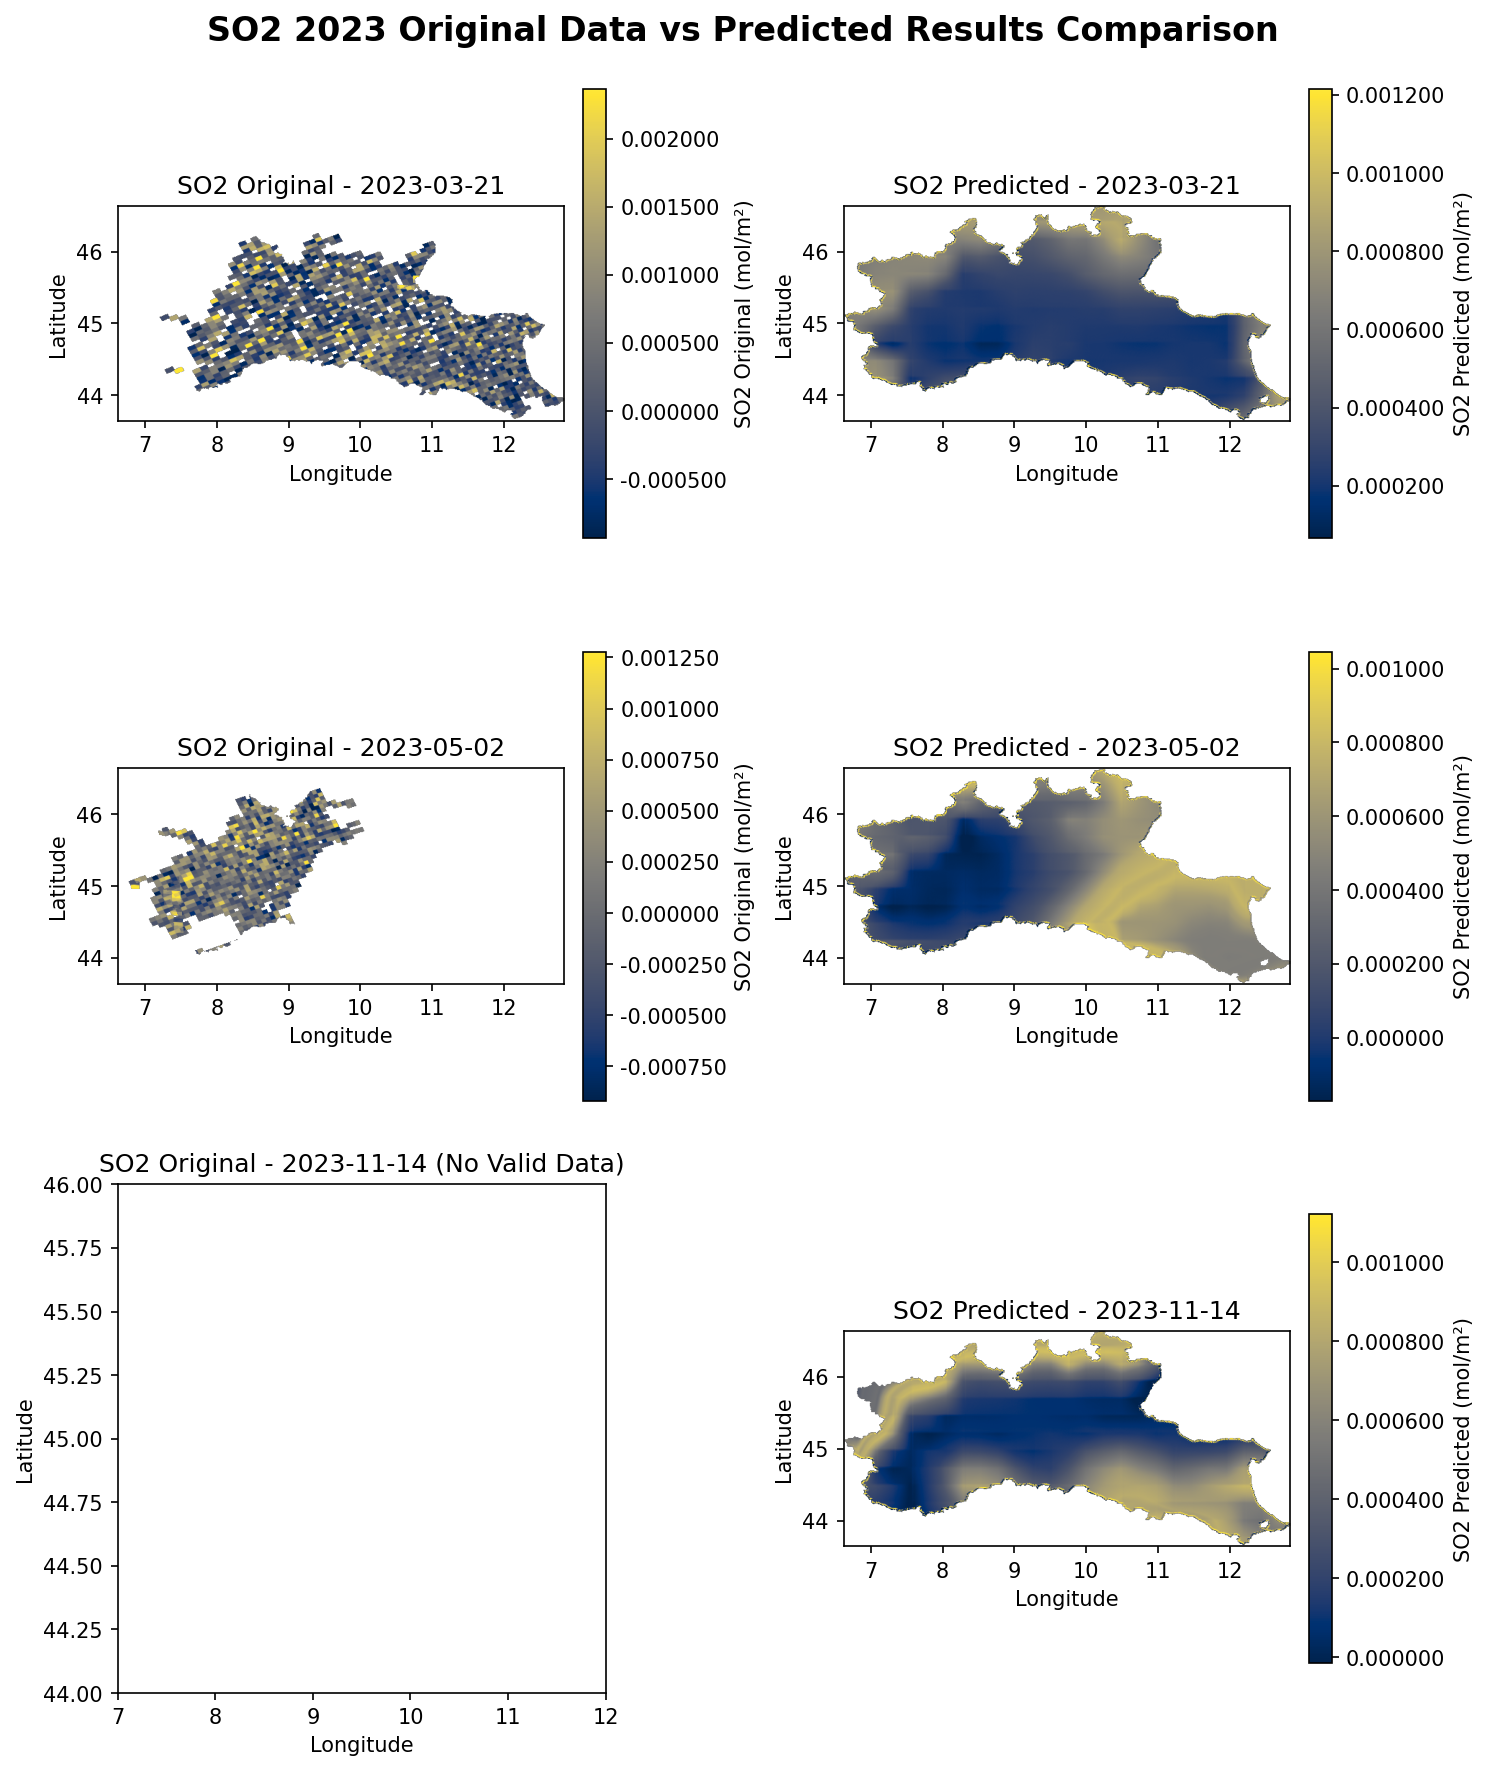

Days plotted: [80, 122, 318]


In [ ]:
# ========= SO2原始数据 vs 预测结果对比可视化（应用NO2逻辑）=========
import numpy as np, matplotlib.pyplot as plt, rasterio, geopandas as gpd, random
from rasterio.mask import mask
from datetime import datetime, timedelta

# 文件路径
PRED_TIF = "/content/drive/MyDrive/3DCNN_Pipeline/artifacts/so2_pred_2023_stack.tif"
ORIG_TIF = "/content/drive/MyDrive/GEE_SO2/SO2_Daily_Multiband_2023.tif"  # 2023年原始数据
AOI_SHP = "/content/drive/MyDrive/AOI/delimitazione_distretto.shp"
NUM = 3

# 读取AOI
aoi = gpd.read_file(AOI_SHP)

# 读取预测数据
with rasterio.open(PRED_TIF) as ds:
    pred_total = ds.count
    bands = sorted(random.sample(range(1, pred_total + 1), NUM))
    aoi_reproj = aoi.to_crs(ds.crs)

    print(f"SO2预测数据信息:")
    print(f"  总波段数: {pred_total}")
    print(f"  空间尺寸: {ds.width} x {ds.height}")
    print(f"  坐标系: {ds.crs}")
    print(f"  随机选择的3天: {bands}")

# 检查原始数据
try:
    with rasterio.open(ORIG_TIF) as ds:
        orig_total = ds.count
        print(f"SO2原始数据信息:")
        print(f"  总波段数: {orig_total}")
        print(f"  空间尺寸: {ds.width} x {ds.height}")
        print(f"  坐标系: {ds.crs}")
    has_original = True
except FileNotFoundError:
    print("SO2原始数据文件不存在，只显示预测数据")
    has_original = False

# 创建子图 (3行2列：每行显示同一天的原始和预测数据)
ncols, nrows = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 12), dpi=150)

# 设置字体
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 2023年起始日期
start_date_2023 = datetime(2023, 1, 1)

for i, b in enumerate(bands):
    current_date = start_date_2023 + timedelta(days=b - 1)

    # 1. 原始数据（左边）
    ax_orig = axes[i, 0]

    if not has_original:
        # 完全空白的图，只显示标题和坐标轴
        ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')} (No Data Available)")
        ax_orig.set_xlabel("Longitude"); ax_orig.set_ylabel("Latitude")
        # 设置坐标范围，但不显示任何内容
        ax_orig.set_xlim(7, 12)
        ax_orig.set_ylim(44, 46)
        ax_orig.set_facecolor('white')
    else:
        try:
            with rasterio.open(ORIG_TIF) as ds:
                clipped_orig, trans_orig = mask(
                    ds, aoi_reproj.geometry, crop=True,
                    nodata=np.nan, filled=True, indexes=b
                )

            arr_orig = np.squeeze(clipped_orig).astype(np.float32)
            valid_orig = np.isfinite(arr_orig)

            if valid_orig.sum() == 0:
                # 完全空白的图，只显示标题和坐标轴
                ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')} (No Valid Data)")
                ax_orig.set_xlabel("Longitude"); ax_orig.set_ylabel("Latitude")
                # 设置坐标范围，但不显示任何内容
                ax_orig.set_xlim(7, 12)
                ax_orig.set_ylim(44, 46)
                ax_orig.set_facecolor('white')
            else:
                h_orig, w_orig = arr_orig.shape
                left_orig, top_orig = trans_orig * (0, 0)
                right_orig, bottom_orig = trans_orig * (w_orig, h_orig)
                extent_orig = [left_orig, right_orig, bottom_orig, top_orig]

                vmin_orig = float(np.percentile(arr_orig[valid_orig], 1))
                vmax_orig = float(np.percentile(arr_orig[valid_orig], 99))
                if vmax_orig <= vmin_orig:
                    vmax_orig = vmin_orig + 1e-12

                masked_arr_orig = np.ma.masked_where(~valid_orig, arr_orig)
                im_orig = ax_orig.imshow(masked_arr_orig, cmap="cividis", vmin=vmin_orig, vmax=vmax_orig,
                                        extent=extent_orig, origin="upper")
                ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')}")
                ax_orig.set_xlabel("Longitude"); ax_orig.set_ylabel("Latitude")
                cbar_orig = fig.colorbar(im_orig, ax=ax_orig, fraction=0.046, pad=0.04, format='%.6f')
                cbar_orig.set_label("SO2 Original (mol/m²)")
        except Exception as e:
            # 完全空白的图，只显示标题和坐标轴
            ax_orig.set_title(f"SO2 Original - {current_date.strftime('%Y-%m-%d')} (Error)")
            ax_orig.set_xlabel("Longitude"); ax_orig.set_ylabel("Latitude")
            # 设置坐标范围，但不显示任何内容
            ax_orig.set_xlim(7, 12)
            ax_orig.set_ylim(44, 46)
            ax_orig.set_facecolor('white')

    # 2. 预测数据（右边）
    ax_pred = axes[i, 1]

    try:
        with rasterio.open(PRED_TIF) as ds:
            clipped_pred, trans_pred = mask(
                ds, aoi_reproj.geometry, crop=True,
                nodata=np.nan, filled=True, indexes=b
            )

        arr_pred = np.squeeze(clipped_pred).astype(np.float32)
        valid_pred = np.isfinite(arr_pred)

        h_pred, w_pred = arr_pred.shape
        left_pred, top_pred = trans_pred * (0, 0)
        right_pred, bottom_pred = trans_pred * (w_pred, h_pred)
        extent_pred = [left_pred, right_pred, bottom_pred, top_pred]

        vmin_pred = float(np.percentile(arr_pred[valid_pred], 1))
        vmax_pred = float(np.percentile(arr_pred[valid_pred], 99))
        if vmax_pred <= vmin_pred:
            vmax_pred = vmin_pred + 1e-12

        masked_arr_pred = np.ma.masked_where(~valid_pred, arr_pred)
        im_pred = ax_pred.imshow(masked_arr_pred, cmap="cividis", vmin=vmin_pred, vmax=vmax_pred,
                                extent=extent_pred, origin="upper")
        ax_pred.set_title(f"SO2 Predicted - {current_date.strftime('%Y-%m-%d')}")
        ax_pred.set_xlabel("Longitude"); ax_pred.set_ylabel("Latitude")
        cbar_pred = fig.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04, format='%.6f')
        cbar_pred.set_label("SO2 Predicted (mol/m²)")
    except Exception as e:
        ax_pred.set_title(f"SO2 Predicted - {current_date.strftime('%Y-%m-%d')} (Error)")
        ax_pred.axis("off")

plt.suptitle("SO2 2023 Original Data vs Predicted Results Comparison", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
print("Days plotted:", bands)